In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from lightgbm import LGBMRegressor, LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, r2_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from scipy import stats
import warnings
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import BaseCrossValidator

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# 1. Analiza danych

Wczytanie danych meczowych

In [19]:
df_2015 = pd.read_csv('dataset_mecze_2015.csv')
df_2016 = pd.read_csv('dataset_mecze_2016.csv')
df_2017 = pd.read_csv('dataset_mecze_2017.csv')
df_2018 = pd.read_csv('dataset_mecze_2018.csv')
df_2019 = pd.read_csv('dataset_mecze_2019.csv')
df_2020 = pd.read_csv('dataset_mecze_2020.csv')
df_2021 = pd.read_csv('dataset_mecze_2021.csv')
df_2022 = pd.read_csv('dataset_mecze_2022.csv')
df_2023 = pd.read_csv('dataset_mecze_2023.csv')
df_2024 = pd.read_csv('dataset_mecze_2024.csv')
df_2025 = pd.read_csv('dataset_mecze_2025.csv')

df = pd.concat([df_2015, df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
df_trening = pd.concat([df_2015, df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df_test = pd.concat([df_2024, df_2025], ignore_index=True)

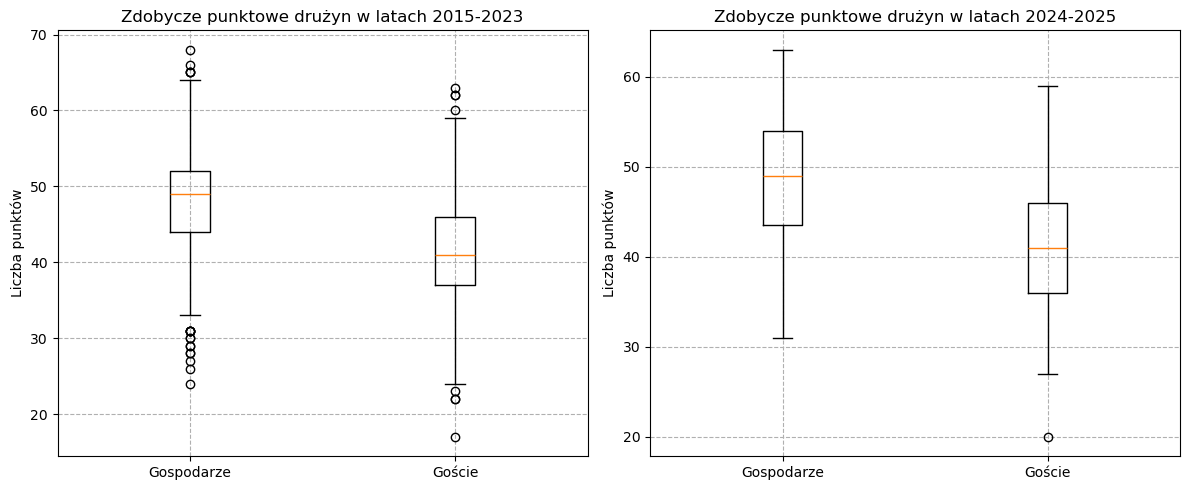

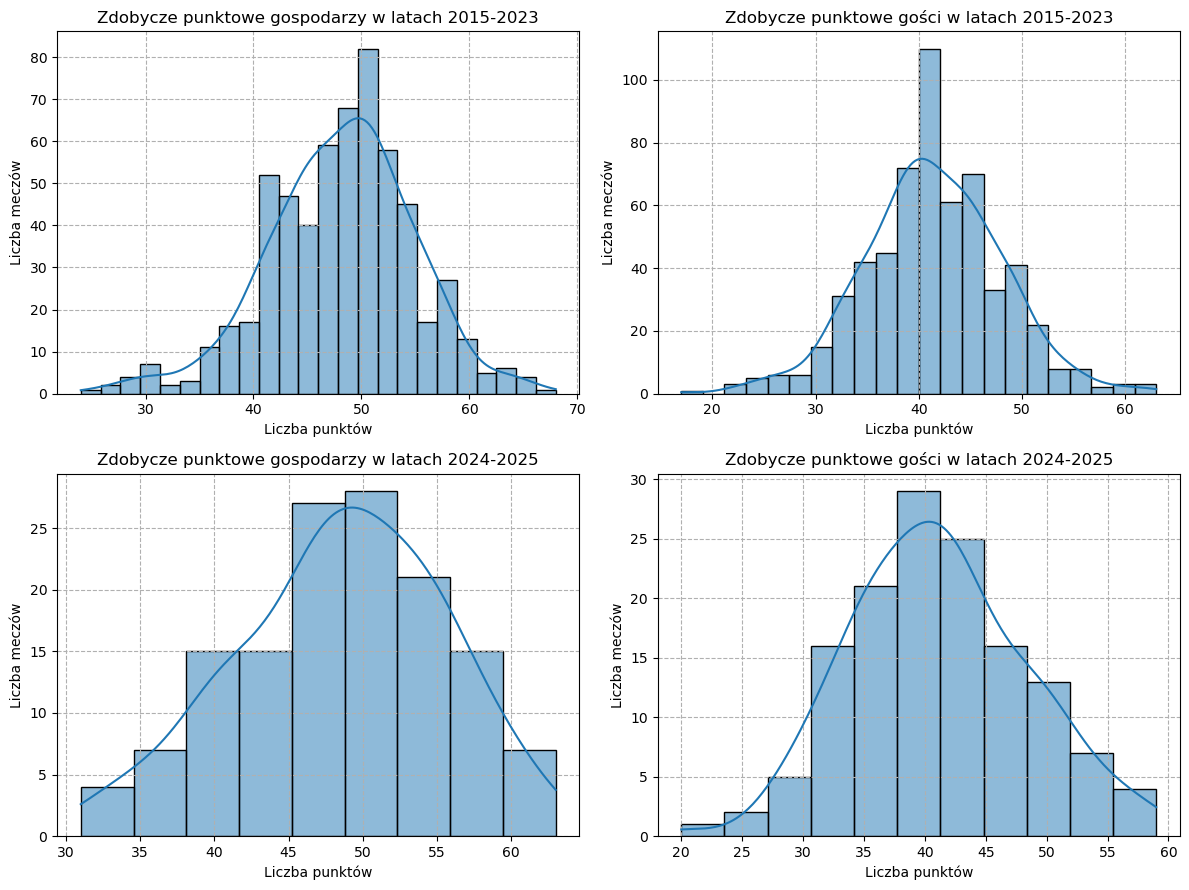

Lata 2015-2023

count    587.000000
mean      48.061329
std        6.797886
min       24.000000
25%       44.000000
50%       49.000000
75%       52.000000
max       68.000000
Name: Punkty gospodarzy, dtype: float64 

count    587.000000
mean      41.357751
std        6.680530
min       17.000000
25%       37.000000
50%       41.000000
75%       46.000000
max       63.000000
Name: Punkty gości, dtype: float64 

Test na normalność dla punktów gospodarzy, Statystyka: 0.9887, p-value: 0.0002
Test na normalność dla punktów gości, Statystyka: 0.9945, p-value: 0.0321

Lata 2023-2025

count    139.000000
mean      48.503597
std        7.007629
min       31.000000
25%       43.500000
50%       49.000000
75%       54.000000
max       63.000000
Name: Punkty gospodarzy, dtype: float64 

count    139.000000
mean      41.107914
std        7.217823
min       20.000000
25%       36.000000
50%       41.000000
75%       46.000000
max       59.000000
Name: Punkty gości, dtype: float64 

Test na normalno

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Zdobycze punktowe drużyn w latach 2015-2023')
plt.boxplot([df_trening['Punkty gospodarzy'], df_trening['Punkty gości']],labels = ['Gospodarze','Goście'])
plt.grid(linestyle = '--')
plt.ylabel('Liczba punktów')

plt.subplot(1,2,2)
plt.title('Zdobycze punktowe drużyn w latach 2024-2025')
plt.boxplot([df_test['Punkty gospodarzy'], df_test['Punkty gości']],labels = ['Gospodarze','Goście'])
plt.grid(linestyle = '--')
plt.ylabel('Liczba punktów')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,9))

plt.subplot(2,2,1)
plt.title('Zdobycze punktowe gospodarzy w latach 2015-2023')
sns.histplot(df_trening['Punkty gospodarzy'],kde=True)
plt.ylabel('Liczba meczów')
plt.xlabel('Liczba punktów')
plt.grid(linestyle = '--')

plt.subplot(2,2,2)
plt.title('Zdobycze punktowe gości w latach 2015-2023')
sns.histplot(df_trening['Punkty gości'],kde=True)
plt.ylabel('Liczba meczów')
plt.xlabel('Liczba punktów')
plt.grid(linestyle = '--')

plt.subplot(2,2,3)
plt.title('Zdobycze punktowe gospodarzy w latach 2024-2025')
sns.histplot(df_test['Punkty gospodarzy'],kde=True)
plt.ylabel('Liczba meczów')
plt.xlabel('Liczba punktów')
plt.grid(linestyle = '--')

plt.subplot(2,2,4)
plt.title('Zdobycze punktowe gości w latach 2024-2025')
sns.histplot(df_test['Punkty gości'],kde=True)
plt.ylabel('Liczba meczów')
plt.xlabel('Liczba punktów')
plt.grid(linestyle = '--')

plt.tight_layout()
plt.show()

print('Lata 2015-2023\n')
print(df_trening['Punkty gospodarzy'].describe(), '\n')
print(df_trening['Punkty gości'].describe(), '\n')
stat, p = stats.shapiro(df_trening['Punkty gospodarzy'])
print(f'Test na normalność dla punktów gospodarzy, Statystyka: {stat:.4f}, p-value: {p:.4f}')
stat, p = stats.shapiro(df_trening['Punkty gości'])
print(f'Test na normalność dla punktów gości, Statystyka: {stat:.4f}, p-value: {p:.4f}\n')

print('Lata 2023-2025\n')
print(df_test['Punkty gospodarzy'].describe(), '\n')
print(df_test['Punkty gości'].describe(), '\n')

stat, p = stats.shapiro(df_test['Punkty gospodarzy'])
print(f'Test na normalność dla punktów gospodarzy, Statystyka: {stat:.4f}, p-value: {p:.4f}')
stat, p = stats.shapiro(df_test['Punkty gości'])
print(f'Test na normalność dla punktów gości, Statystyka: {stat:.4f}, p-value: {p:.4f}')

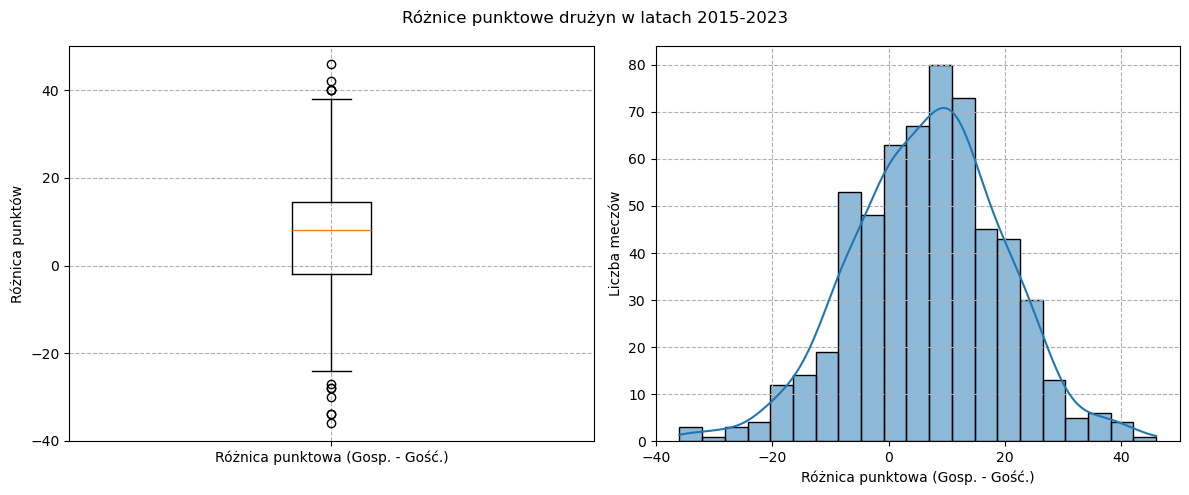

count    587.000000
mean       6.703578
std       12.917725
min      -36.000000
25%       -2.000000
50%        8.000000
75%       14.500000
max       46.000000
dtype: float64
Test na normalność: Statystyka: 0.9949, p-value: 0.0509


In [21]:
plt.figure(figsize=(12,5))
plt.suptitle('Różnice punktowe drużyn w latach 2015-2023')

plt.subplot(1,2,1)
plt.boxplot([df_trening['Punkty gospodarzy'] - df_trening['Punkty gości']],labels = ['Różnica punktowa (Gosp. - Gość.)'])
plt.grid(linestyle = '--')
plt.ylabel('Różnica punktów')

plt.subplot(1,2,2)
sns.histplot(df_trening['Punkty gospodarzy'] - df_trening['Punkty gości'], kde= True)
plt.ylabel('Liczba meczów')
plt.xlabel('Różnica punktowa (Gosp. - Gość.)')
plt.grid(linestyle = '--')

plt.tight_layout()
plt.show()

df_trening_rp = df_trening['Punkty gospodarzy'] - df_trening['Punkty gości']
print(df_trening_rp.describe())

stat, p = stats.shapiro(df_trening['Punkty gospodarzy']-df_trening['Punkty gości'])
print(f'Test na normalność: Statystyka: {stat:.4f}, p-value: {p:.4f}')

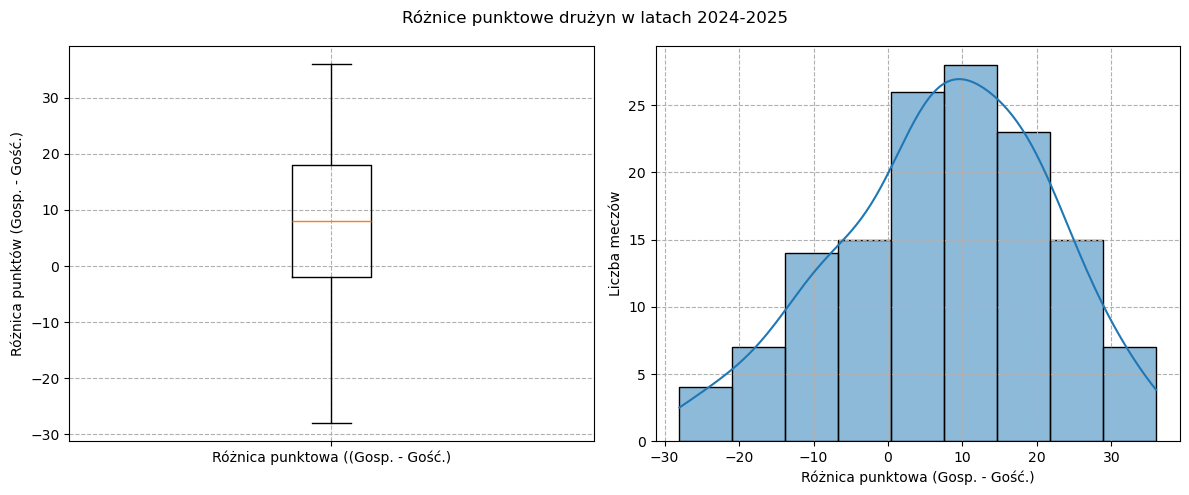

count    139.000000
mean       7.395683
std       13.954179
min      -28.000000
25%       -2.000000
50%        8.000000
75%       18.000000
max       36.000000
dtype: float64
Test na normalność, Statystyka: 0.9841, p-value: 0.1074


In [22]:
plt.figure(figsize=(12,5))
plt.suptitle('Różnice punktowe drużyn w latach 2024-2025')

plt.subplot(1,2,1)
plt.boxplot([df_test['Punkty gospodarzy'] - df_test['Punkty gości']],labels = ['Różnica punktowa ((Gosp. - Gość.)'])
plt.grid(linestyle = '--')
plt.ylabel('Różnica punktów (Gosp. - Gość.)')

plt.subplot(1,2,2)
sns.histplot(df_test['Punkty gospodarzy'] - df_test['Punkty gości'], kde = True)
plt.ylabel('Liczba meczów')
plt.xlabel('Różnica punktowa (Gosp. - Gość.)')
plt.grid(linestyle = '--')

plt.tight_layout()
plt.show()

df_test_rp = df_test['Punkty gospodarzy'] - df_test['Punkty gości']
print(df_test_rp.describe())

stat, p = stats.shapiro(df_test['Punkty gospodarzy']-df_test['Punkty gości'])
print(f'Test na normalność, Statystyka: {stat:.4f}, p-value: {p:.4f}')

Różnica punktowa dla sezonu 2015

In [23]:
df_pretrening_rp = df_2015['Punkty gospodarzy'] - df_2015['Punkty gości']
df_pretrening_rp.describe()

count    64.000000
mean      8.546875
std      11.990644
min     -18.000000
25%       0.000000
50%       8.000000
75%      16.000000
max      36.000000
dtype: float64

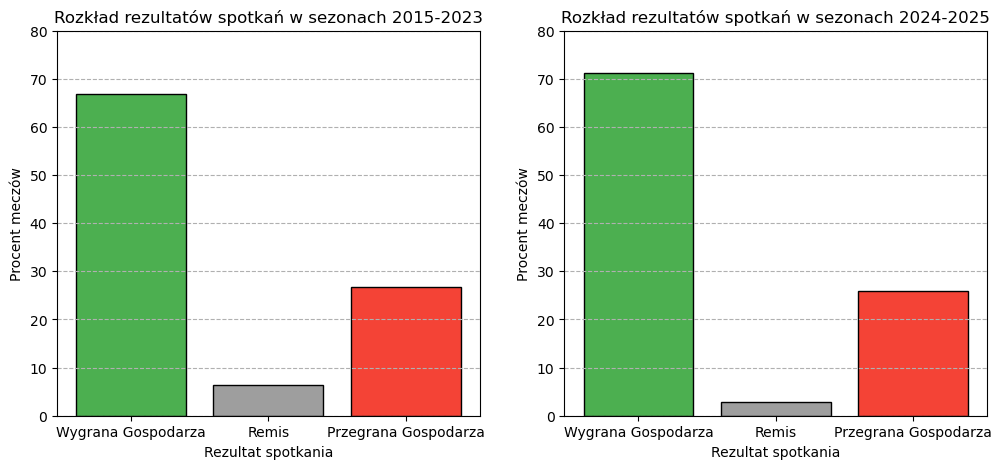

[66.95059625  6.3032368  26.74616695]
[71.22302158  2.87769784 25.89928058]


In [24]:
def przypisz_rezultat(roznica):
    if roznica > 0:
        return 'Wygrana Gospodarza'
    elif roznica == 0:
        return 'Remis'
    else:
        return 'Przegrana Gospodarza'

rezultaty_test = df_test_rp.apply(przypisz_rezultat)
rezultaty_trening = df_trening_rp.apply(przypisz_rezultat)


counts_test = rezultaty_test.value_counts().reindex(['Wygrana Gospodarza', 'Remis', 'Przegrana Gospodarza']).fillna(0)
counts_trening = rezultaty_trening.value_counts().reindex(['Wygrana Gospodarza', 'Remis', 'Przegrana Gospodarza']).fillna(0)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

plt.bar(counts_trening.index, counts_trening.values/len(df_trening_rp)*100, color=['#4CAF50', '#9E9E9E', '#F44336'], edgecolor='black')
plt.xlabel('Rezultat spotkania')
plt.ylabel('Procent meczów')
plt.title('Rozkład rezultatów spotkań w sezonach 2015-2023')
plt.grid(axis='y', linestyle='--',)
plt.ylim(0,80)

plt.subplot(1,2,2)

plt.bar(counts_test.index, counts_test.values/len(df_test_rp)*100, color=['#4CAF50', '#9E9E9E', '#F44336'], edgecolor='black')
plt.xlabel('Rezultat spotkania')
plt.ylabel('Procent meczów')
plt.title('Rozkład rezultatów spotkań w sezonach 2024-2025')
plt.grid(axis='y', linestyle='--',)
plt.ylim(0,80)

plt.show()

print(counts_trening.values/len(df_trening_rp)*100)
print(counts_test.values/len(df_test_rp)*100)

<Figure size 1200x600 with 0 Axes>

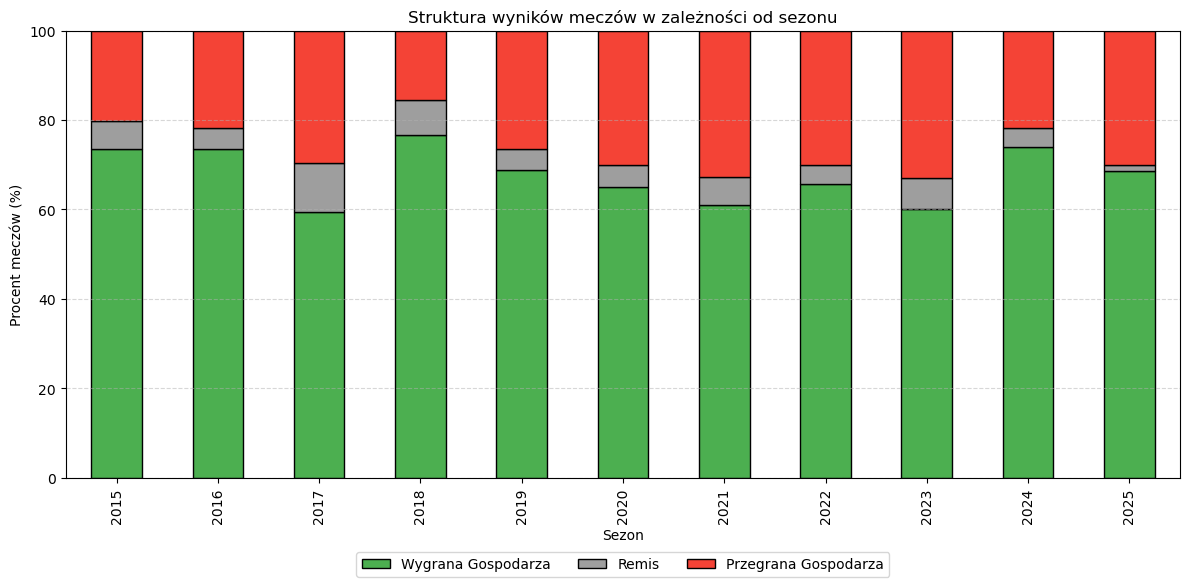

In [25]:
df['Różnica'] = df['Punkty gospodarzy'] - df['Punkty gości']

df['Wynik'] = df['Różnica'].apply(przypisz_rezultat)


season_stats = df.groupby(['Sezon', 'Wynik']).size().unstack(fill_value=0)

season_stats['Total'] = season_stats.sum(axis=1)
season_stats['Pct_Wygrana'] = (season_stats.get('Wygrana Gospodarza', 0) / season_stats['Total']) * 100
season_stats['Pct_Remis'] = (season_stats.get('Remis', 0) / season_stats['Total']) * 100
season_stats['Pct_Przegrana'] = (season_stats.get('Przegrana Gospodarza', 0) / season_stats['Total']) * 100

season_stats = season_stats.reset_index()


plot_data = season_stats.set_index('Sezon')[['Pct_Wygrana', 'Pct_Remis', 'Pct_Przegrana']]

plot_data = plot_data[['Pct_Wygrana', 'Pct_Remis', 'Pct_Przegrana']]

colors = ['#4CAF50', '#9E9E9E', '#F44336']

plt.figure(figsize=(12, 6))
plot_data.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6), edgecolor='black')
plt.title('Struktura wyników meczów w zależności od sezonu')
plt.ylabel('Procent meczów (%)')
plt.xlabel('Sezon')
plt.legend(['Wygrana Gospodarza', 'Remis', 'Przegrana Gospodarza'], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Analiza wyników indywidualnych

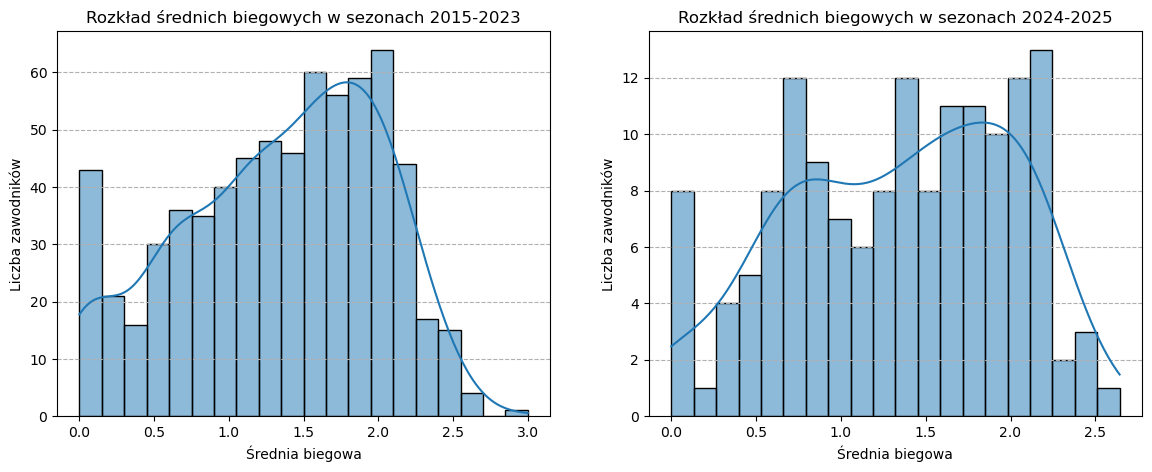

In [26]:
df_2015 = pd.read_csv('zawodnicy_2015.csv')
df_2016 = pd.read_csv('zawodnicy_2016.csv')
df_2017 = pd.read_csv('zawodnicy_2017.csv')
df_2018 = pd.read_csv('zawodnicy_2018.csv')
df_2019 = pd.read_csv('zawodnicy_2019.csv')
df_2020 = pd.read_csv('zawodnicy_2020.csv')
df_2021 = pd.read_csv('zawodnicy_2021.csv')
df_2022 = pd.read_csv('zawodnicy_2022.csv')
df_2023 = pd.read_csv('zawodnicy_2023.csv')
df_2024 = pd.read_csv('zawodnicy_2024.csv')
df_2025 = pd.read_csv('zawodnicy_2025.csv')

df_zaw_trening = pd.concat([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,df_2021, df_2022,df_2023], ignore_index=True)
df_zaw_test = pd.concat([df_2024,df_2025], ignore_index=True)

col_name = 'SREDNIA' 

df_zaw_trening[col_name] = pd.to_numeric(df_zaw_trening[col_name], errors='coerce')
df_zaw_test[col_name] = pd.to_numeric(df_zaw_test[col_name], errors='coerce')

df_zaw_trening = df_zaw_trening.dropna(subset=[col_name])
df_zaw_test = df_zaw_test.dropna(subset=[col_name])

plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)

sns.histplot(data=df_zaw_trening, x=col_name, kde=True,bins = 20)

plt.title('Rozkład średnich biegowych w sezonach 2015-2023')
plt.xlabel('Średnia biegowa')
plt.ylabel('Liczba zawodników')
plt.grid(linestyle = '--', axis = 'y')

plt.subplot(1,2,2)

sns.histplot(data=df_zaw_test, x=col_name,kde=True, bins = 20)

plt.title('Rozkład średnich biegowych w sezonach 2024-2025')
plt.xlabel('Średnia biegowa')
plt.ylabel('Liczba zawodników')
plt.grid(linestyle = '--', axis = 'y')
plt.show()

In [27]:
print('Lata 2015-2023')
print(df_zaw_trening[col_name].describe())
print('Średnia ważona: ',np.sum(df_zaw_trening['SREDNIA'] * df_zaw_trening['BIEGI'])/df_zaw_trening['BIEGI'].sum())

print('\nLata 2023-2025')
print(df_zaw_test[col_name].describe())
print('Średnia ważona: ',np.sum(df_zaw_test['SREDNIA'] * df_zaw_test['BIEGI'])/df_zaw_test['BIEGI'].sum())

Lata 2015-2023
count    680.000000
mean       1.341154
std        0.666988
min        0.000000
25%        0.848026
50%        1.447684
75%        1.868391
max        3.000000
Name: SREDNIA, dtype: float64
Średnia ważona:  1.6508931480308706

Lata 2023-2025
count    151.000000
mean       1.343521
std        0.659086
min        0.000000
25%        0.805200
50%        1.406977
75%        1.919198
max        2.642857
Name: SREDNIA, dtype: float64
Średnia ważona:  1.650384061449832


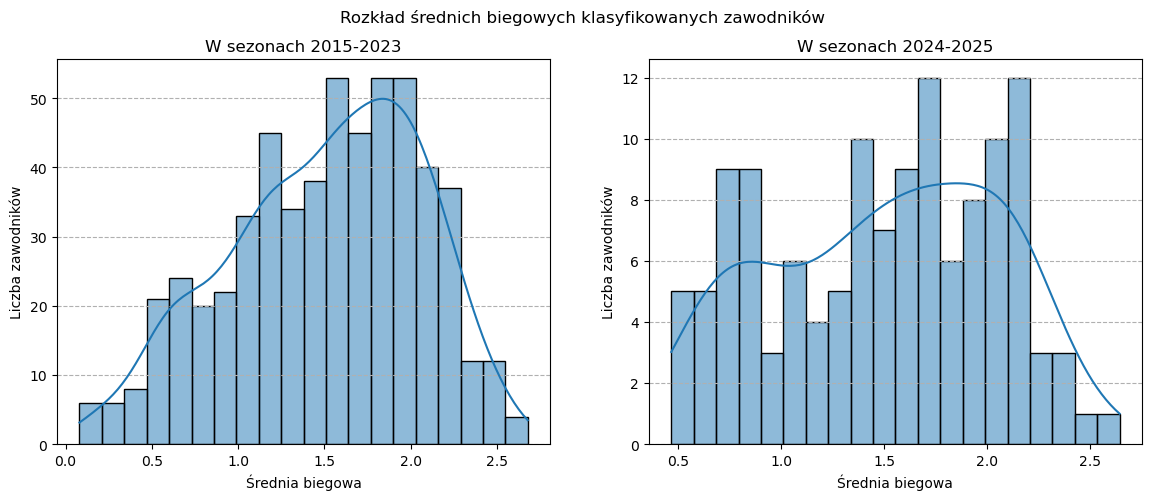

In [28]:
df_zaw_trening = df_zaw_trening[df_zaw_trening['BIEGI']>=15]
df_zaw_trening[col_name] = pd.to_numeric(df_zaw_trening[col_name], errors='coerce')
df_zaw_trening = df_zaw_trening.dropna(subset=[col_name])


df_zaw_test = df_zaw_test[df_zaw_test['BIEGI']>=15]
df_zaw_test[col_name] = pd.to_numeric(df_zaw_test[col_name], errors='coerce')
df_zaw_test = df_zaw_test.dropna(subset=[col_name])


plt.figure(figsize=(14, 5))
plt.suptitle('Rozkład średnich biegowych klasyfikowanych zawodników')
plt.subplot(1,2,1)
sns.histplot(
    data=df_zaw_trening, 
    x=col_name,            
    kde=True,              
    bins=20,                    
)

plt.title('W sezonach 2015-2023')
plt.xlabel('Średnia biegowa')
plt.ylabel('Liczba zawodników')
plt.grid(linestyle = '--', axis = 'y')

plt.subplot(1,2,2)
sns.histplot(
    data=df_zaw_test, 
    x=col_name,            
    kde=True,              
    bins=20,                    
)

plt.title('W sezonach 2024-2025')
plt.xlabel('Średnia biegowa')
plt.ylabel('Liczba zawodników')
plt.grid(linestyle = '--', axis = 'y')

plt.show()

In [29]:
print('Lata 2015-2023')
print(df_zaw_trening[col_name].describe())
print('Średnia ważona: ',np.sum(df_zaw_trening['SREDNIA'] * df_zaw_trening['BIEGI'])/df_zaw_trening['BIEGI'].sum())

print('\nLata 2023-2025')
print(df_zaw_test[col_name].describe())
print('Średnia ważona: ',np.sum(df_zaw_test['SREDNIA'] * df_zaw_test['BIEGI'])/df_zaw_test['BIEGI'].sum())

Lata 2015-2023
count    566.000000
mean       1.508275
std        0.554367
min        0.080000
25%        1.127000
50%        1.570115
75%        1.953500
max        2.679000
Name: SREDNIA, dtype: float64
Średnia ważona:  1.6716770079869572

Lata 2023-2025
count    128.000000
mean       1.502628
std        0.549408
min        0.466667
25%        1.040389
50%        1.564660
75%        1.975825
max        2.642857
Name: SREDNIA, dtype: float64
Średnia ważona:  1.6694759985342615


In [30]:
stat, p = stats.shapiro(df_zaw_trening[col_name])
print(f'Test na normalność dla SBP dla klasyfikowanych zawodników w latach 2015-2023, Statystyka: {stat:.3f}, p-value: {p}')

Test na normalność dla SBP dla klasyfikowanych zawodników w latach 2015-2023, Statystyka: 0.978, p-value: 1.2683394139298423e-07


# 2. Inżynieria cech

Czyszczenie danych, stworzenie kolumny zawierającej wynik meczu oraz różnicę punktową

In [31]:
def pre_procesing(df):
    df['Data'] = df['Data'].str.replace(',', '', regex=False)
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    df = df.sort_values('Data').reset_index(drop=True)

    df['Punkty gospodarzy'] = pd.to_numeric(df['Punkty gospodarzy'], errors='coerce')
    df['Punkty gości'] = pd.to_numeric(df['Punkty gości'], errors='coerce')

    df['Różnica_punktowa'] = df['Punkty gospodarzy'] - df['Punkty gości']
    
    df['Różnica_punktowa_gosc'] = df['Punkty gości'] - df['Punkty gospodarzy']

    def get_match_result(diff):
        if diff > 0: return 2
        elif diff < 0: return 0
        else: return 1
    df['Wynik_meczu'] = df['Różnica_punktowa'].apply(get_match_result)

    return df

Stworzenie formy drużyny

In [32]:
def create_current_form(df, windows):
    window1, window2 = windows 
    
    season_home_stats = df.groupby(['Sezon', 'Drużyna gospodarzy'])['Różnica_punktowa'].mean().reset_index()
    season_home_stats.columns = ['Sezon', 'Drużyna', 'Avg_Home_Points'] 

    season_away_stats = df.groupby(['Sezon', 'Drużyna gości'])['Różnica_punktowa_gosc'].mean().reset_index()
    season_away_stats.columns = ['Sezon', 'Drużyna', 'Avg_Away_Points'] 

    yearly_stats = pd.merge(season_home_stats, season_away_stats, on=['Sezon', 'Drużyna'], how='outer')
    yearly_stats['Avg_Overall_Points'] = yearly_stats[['Avg_Home_Points', 'Avg_Away_Points']].mean(axis=1)

    prev_yearly_stats_host = yearly_stats.copy()
    prev_yearly_stats_host['Sezon'] += 1
    prev_yearly_stats_host.columns = [
        'Sezon', 'Drużyna', 
        'Forma_gospodarzy_dom_poprzedni_sezon', 
        'Forma_gospodarzy_wyjazd_poprzedni_sezon',
        'Forma_gospodarzy_overall_poprzedni_sezon'
    ]
    df = pd.merge(df, prev_yearly_stats_host, left_on=['Sezon', 'Drużyna gospodarzy'], right_on=['Sezon', 'Drużyna'], how='left')
    df = df.drop(columns=['Drużyna'])

    prev_yearly_stats_guest = yearly_stats.copy()
    prev_yearly_stats_guest['Sezon'] += 1
    prev_yearly_stats_guest.columns = [
        'Sezon', 'Drużyna', 
        'Forma_gości_dom_poprzedni_sezon', 
        'Forma_gości_wyjazd_poprzedni_sezon',
        'Forma_gości_overall_poprzedni_sezon'
    ]
    df = pd.merge(df, prev_yearly_stats_guest, left_on=['Sezon', 'Drużyna gości'], right_on=['Sezon', 'Drużyna'], how='left')
    df = df.drop(columns=['Drużyna'])

    cols_home = ['Data', 'Sezon', 'Drużyna gospodarzy', 'Różnica_punktowa', 
                 'Forma_gospodarzy_dom_poprzedni_sezon', 'Forma_gospodarzy_overall_poprzedni_sezon']
    home_matches = df[cols_home].copy()
    home_matches.columns = ['Data', 'Sezon', 'Drużyna', 'Punkty', 'Hist_Specyficzna', 'Hist_Overall']
    home_matches['Czy_dom'] = True

    cols_away = ['Data', 'Sezon', 'Drużyna gości', 'Różnica_punktowa_gosc', 
                 'Forma_gości_wyjazd_poprzedni_sezon', 'Forma_gości_overall_poprzedni_sezon']
    away_matches = df[cols_away].copy()
    away_matches.columns = ['Data', 'Sezon', 'Drużyna', 'Punkty', 'Hist_Specyficzna', 'Hist_Overall']
    away_matches['Czy_dom'] = False

    long_df = pd.concat([home_matches, away_matches]).sort_values(['Data'])
    
    mask_dom = long_df['Czy_dom'] == True
    long_df.loc[mask_dom, 'Hist_Specyficzna'] = long_df.loc[mask_dom, 'Hist_Specyficzna'].fillna(8)
    long_df.loc[~mask_dom, 'Hist_Specyficzna'] = long_df.loc[~mask_dom, 'Hist_Specyficzna'].fillna(-8)
    
    long_df['Hist_Overall'] = long_df['Hist_Overall'].fillna(0)

    
    def calculate_weighted_form(df_grouped, col_points, col_history, window_size):
        roll_sum = df_grouped[col_points].transform(lambda x: x.rolling(window=window_size, min_periods=1).sum())
        
        roll_count = df_grouped[col_points].transform(lambda x: x.rolling(window=window_size, min_periods=1).count())
        
        hist_val = df_grouped[col_history].transform(lambda x: x)
        
        missing_games = window_size - roll_count
        
        return (roll_sum + (missing_games * hist_val)) / window_size

    g_spec = long_df.groupby(['Sezon', 'Drużyna', 'Czy_dom'])
    long_df['Form_After'] = calculate_weighted_form(g_spec, 'Punkty', 'Hist_Specyficzna', window1)

    g_over = long_df.groupby(['Sezon', 'Drużyna'])
    long_df['Form_After_Overall'] = calculate_weighted_form(g_over, 'Punkty', 'Hist_Overall', window2)

    df = df.sort_values('Data')
    long_df = long_df.sort_values('Data')

    def get_recent_form(main_df, lookup_df, team_col_main, is_home_lookup):
        lookup_subset = lookup_df[lookup_df['Czy_dom'] == is_home_lookup].copy()
        merged = pd.merge_asof(
            main_df,
            lookup_subset[['Data', 'Sezon', 'Drużyna', 'Form_After']],
            left_on='Data', right_on='Data',
            left_by=['Sezon', team_col_main], right_by=['Sezon', 'Drużyna'],
            direction='backward', allow_exact_matches=False
        )
        return merged['Form_After']
    
    def get_recent_form_v2(main_df, lookup_df, team_col_main):
        merged = pd.merge_asof(
            main_df,
            lookup_df[['Data', 'Sezon', 'Drużyna', 'Form_After_Overall']],
            left_on='Data', right_on='Data',
            left_by=['Sezon', team_col_main], right_by=['Sezon', 'Drużyna'],
            direction='backward', allow_exact_matches=False
        )
        return merged['Form_After_Overall']

    df['Forma_gospodarz_dom'] = get_recent_form(df, long_df, 'Drużyna gospodarzy', True)
    df['Forma_gospodarz_wyjazd'] = get_recent_form(df, long_df, 'Drużyna gospodarzy', False)
    df['Forma_gosc_dom'] = get_recent_form(df, long_df, 'Drużyna gości', True)
    df['Forma_gosc_wyjazd'] = get_recent_form(df, long_df, 'Drużyna gości', False)
    
    df['Forma_gospodarz_poprzedni_sezon'] = get_recent_form_v2(df, long_df, 'Drużyna gospodarzy')
    df['Forma_gosci_poprzedni_sezon'] = get_recent_form_v2(df, long_df, 'Drużyna gości')

    df['Forma_gospodarz_dom'] = df['Forma_gospodarz_dom'].fillna(df['Forma_gospodarzy_dom_poprzedni_sezon'])
    df['Forma_gospodarz_wyjazd'] = df['Forma_gospodarz_wyjazd'].fillna(df['Forma_gospodarzy_wyjazd_poprzedni_sezon'])
    df['Forma_gosc_dom'] = df['Forma_gosc_dom'].fillna(df['Forma_gości_dom_poprzedni_sezon'])
    df['Forma_gosc_wyjazd'] = df['Forma_gosc_wyjazd'].fillna(df['Forma_gości_wyjazd_poprzedni_sezon'])
    
    df['Forma_gospodarz_poprzedni_sezon'] = df['Forma_gospodarz_poprzedni_sezon'].fillna(df['Forma_gospodarzy_overall_poprzedni_sezon'])
    df['Forma_gosci_poprzedni_sezon'] = df['Forma_gosci_poprzedni_sezon'].fillna(df['Forma_gości_overall_poprzedni_sezon'])

    df = df.drop(columns=['Różnica_punktowa_gosc'])

    cols_to_fill_gosp = [
        'Forma_gospodarzy_dom_poprzedni_sezon',
        'Forma_gospodarzy_wyjazd_poprzedni_sezon',
        'Forma_gospodarz_dom',
        'Forma_gospodarz_wyjazd',
        'Forma_gospodarz_poprzedni_sezon'
    ]

    cols_to_fill_gosc = [
        'Forma_gości_dom_poprzedni_sezon',
        'Forma_gości_wyjazd_poprzedni_sezon',
        'Forma_gosc_dom',
        'Forma_gosc_wyjazd',
        'Forma_gosci_poprzedni_sezon'
    ]
    
    df[cols_to_fill_gosp] = df[cols_to_fill_gosp].fillna(8)
    df[cols_to_fill_gosc] = df[cols_to_fill_gosc].fillna(-8)
    df['Różnica_form'] = df['Forma_gospodarz_dom'] - df['Forma_gosc_wyjazd']

    return df


Utworzenie siły drużyny i jej składowych

In [33]:
def create_team_power(df):

    cols_gosc = [f'Zawodnik{i}' for i in range(1, 9)]
    cols_gosp = [f'Zawodnik{i}' for i in range(9, 17)]
    
    junior_slots = {'Zawodnik6', 'Zawodnik7', 'Zawodnik14', 'Zawodnik15'}
    
    fraza_zz = 'Zaw. Zastępstwo'

    files_1liga = {
        2015: 'zawodnicy_2015.csv', 2016: 'zawodnicy_2016.csv',
        2017: 'zawodnicy_2017.csv', 2018: 'zawodnicy_2018.csv',
        2019: 'zawodnicy_2019.csv', 2020: 'zawodnicy_2020.csv',
        2021: 'zawodnicy_2021.csv', 2022: 'zawodnicy_2022.csv',
        2023: 'zawodnicy_2023.csv', 2024: 'zawodnicy_2024.csv'
    }
    files_2liga = {
        2015: 'zawodnicy_1liga_2015.csv', 2016: 'zawodnicy_1liga_2016.csv',
        2017: 'zawodnicy_1liga_2017.csv', 2018: 'zawodnicy_1liga_2018.csv',
        2019: 'zawodnicy_1liga_2019.csv', 2020: 'zawodnicy_1liga_2020.csv',
        2021: 'zawodnicy_1liga_2021.csv', 2022: 'zawodnicy_1liga_2022.csv',
        2023: 'zawodnicy_1liga_2023.csv', 2024: 'zawodnicy_1liga_2024.csv'
    }

    avg_dfs = []

    def load_riders(file_dict, divisor=1.0):
        for sezon, fname in file_dict.items():
 
            tmp = pd.read_csv(fname)
            tmp['Sezon_Source'] = sezon
            
            cols_to_convert = ['SREDNIA', 'DOM', 'WYJAZD']
            for col in cols_to_convert:
                if col in tmp.columns:
                    if tmp[col].dtype == object:
                        tmp[col] = tmp[col].astype(str).str.replace(',', '.')
                    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
                    tmp[col] = tmp[col] / divisor

            if 'BIEGI' in tmp.columns:
                tmp['BIEGI'] = pd.to_numeric(tmp['BIEGI'], errors='coerce').fillna(0)
                tmp = tmp[tmp['BIEGI'] >= 15]
                
            avg_dfs.append(tmp)


    load_riders(files_2liga, divisor=1.3)
    load_riders(files_1liga, divisor=1.0)

    df_avg_all = pd.concat(avg_dfs, ignore_index=True)

    def normalize_name(name):
        if not isinstance(name, str):
            return name
        parts = name.strip().split(' ', 1)
        if len(parts) == 2:
            return f"{parts[1]} {parts[0]}"
        return name

    if 'ZAWODNIK' in df_avg_all.columns:
        df_avg_all['Zawodnik_norm'] = df_avg_all['ZAWODNIK'].apply(normalize_name)
        df_avg_all['Sezon_Available'] = df_avg_all['Sezon_Source'] + 1

        df_unique = df_avg_all.drop_duplicates(subset=['Sezon_Available', 'Zawodnik_norm'], keep='last')
        avg_lookup = df_unique.set_index(['Sezon_Available', 'Zawodnik_norm'])['SREDNIA'].to_dict()
        
        def calculate_split_strength(row, player_cols):
            season = row['Sezon']
            
            senior_values = []
            junior_values = []
            
            all_valid_riders_averages = []
            
            zz_slots_types = [] 

            for col in player_cols:
                player_name = row.get(col)
                
                is_junior_slot = col in junior_slots
                default_val = 0.625 if is_junior_slot else 1.5
                
                if pd.notna(player_name) and isinstance(player_name, str):
                    clean_name = normalize_name(player_name)
                    raw_name = player_name.strip()
                    
                    if (raw_name == fraza_zz) or (clean_name == fraza_zz) or (fraza_zz in raw_name):
                        if is_junior_slot:
                            zz_slots_types.append('junior')
                        else:
                            zz_slots_types.append('senior')
                    else:
                        avg = avg_lookup.get((season, clean_name))
                        if avg is None:
                             avg = avg_lookup.get((season, raw_name), default_val)
                        
                        all_valid_riders_averages.append(avg)
                        
                        if is_junior_slot:
                            junior_values.append(avg)
                        else:
                            senior_values.append(avg)
                else:
                    pass


            zz_value = 1.5
            if len(zz_slots_types) > 0:
                if len(all_valid_riders_averages) > 0:
                    all_valid_riders_averages.sort(reverse=True)
                    top_4 = all_valid_riders_averages[:4]
                    zz_value = sum(top_4) / len(top_4)
            
            for slot_type in zz_slots_types:
                if slot_type == 'senior':
                    senior_values.append(zz_value)
                else:
                    junior_values.append(zz_value)


            senior_values.sort(reverse=True)
            strength_senior = sum(senior_values[:5])
            
            strength_junior = sum(junior_values)

            return pd.Series([strength_senior, strength_junior])

        if not df.empty:
            
            df[['Sila_Seniorzy_Goscie', 'Sila_Juniorzy_Goscie']] = df.apply(
                lambda row: calculate_split_strength(row, cols_gosc), axis=1
            )

            df[['Sila_Seniorzy_Gospodarze', 'Sila_Juniorzy_Gospodarze']] = df.apply(
                lambda row: calculate_split_strength(row, cols_gosp), axis=1
            )

            df['Sila_druzyny_gosci'] = df['Sila_Seniorzy_Goscie'] + df['Sila_Juniorzy_Goscie']
            df['Sila_druzyny_gospodarzy'] = df['Sila_Seniorzy_Gospodarze'] + df['Sila_Juniorzy_Gospodarze']
            
            df['Różnica_sił'] = df['Sila_druzyny_gospodarzy'] - df['Sila_druzyny_gosci']
            df['Różnica_Seniorzy'] = df['Sila_Seniorzy_Gospodarze'] - df['Sila_Seniorzy_Goscie']
            df['Różnica_Juniorzy'] = df['Sila_Juniorzy_Gospodarze'] - df['Sila_Juniorzy_Goscie']

    return df

Zastosowanie powyższych funkcji

In [34]:
def inz_cech(df, windows):
    df = pre_procesing(df)
    df = create_current_form(df, windows)
    df = create_team_power(df)

    return df

df = inz_cech(df,[3,3])

In [35]:
df = df[df['Sezon']>2015]

df_trening = df[df['Sezon']<=2023]
df_test = df[df['Sezon']>2023]

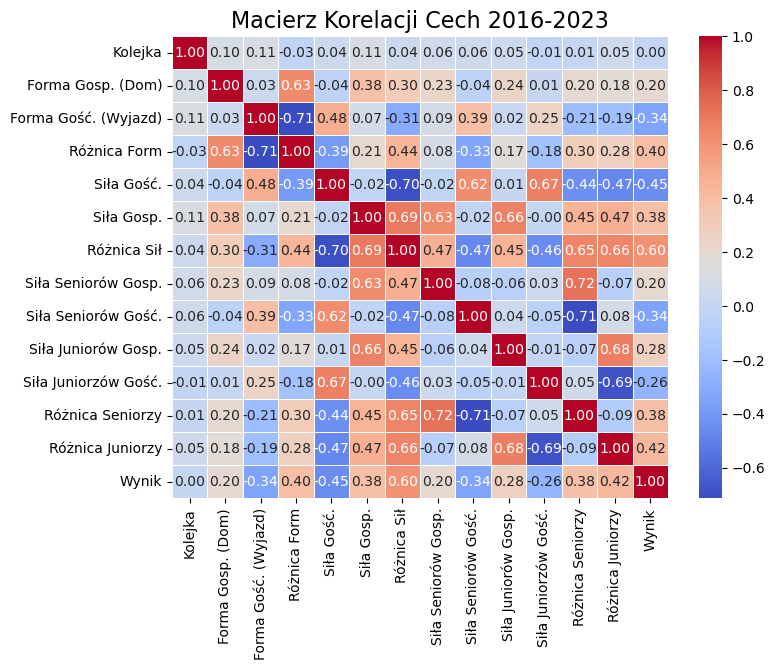

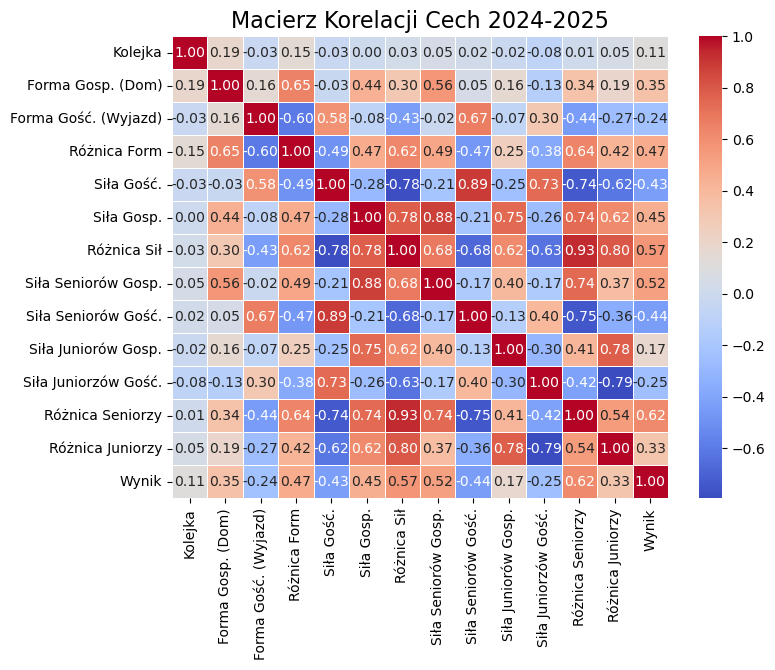

In [36]:
features = [
    'Kolejka'
    ,'Forma_gospodarz_dom'
    , 'Forma_gosc_wyjazd'
    ,'Różnica_form'
    ,'Sila_druzyny_gosci',	'Sila_druzyny_gospodarzy'
    ,'Różnica_sił'
    ,'Sila_Seniorzy_Gospodarze', 'Sila_Seniorzy_Goscie'
    ,'Sila_Juniorzy_Gospodarze', 'Sila_Juniorzy_Goscie'
    ,'Różnica_Seniorzy'
    ,'Różnica_Juniorzy'
    ,'Różnica_punktowa'
    ]


ladne_nazwy = [
    'Kolejka', 'Forma Gosp. (Dom)', 'Forma Gość. (Wyjazd)', 'Różnica Form',
    'Siła Gość.', 'Siła Gosp.', 'Różnica Sił',
    'Siła Seniorów Gosp.', 'Siła Seniorów Gość.',
    'Siła Juniorów Gosp.', 'Siła Juniorzów Gość.',
    'Różnica Seniorzy', 'Różnica Juniorzy', 'Wynik'
]

df_corr_trening = df_trening[features]

correlation_matrix_trening = df_corr_trening.corr(method='spearman')


plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix_trening,
    annot=True,
    cmap='coolwarm',
    fmt=".2f", 
    linewidths=.5,
    cbar=True ,
    xticklabels=ladne_nazwy,
    yticklabels=ladne_nazwy           
)

plt.title('Macierz Korelacji Cech 2016-2023', fontsize=16)
plt.show()



df_corr_test = df_test[features]

correlation_matrix_test = df_corr_test.corr(method='spearman')


plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix_test,
    annot=True,
    cmap='coolwarm',
    fmt=".2f", 
    linewidths=.5,
    cbar=True,
    xticklabels=ladne_nazwy,
    yticklabels=ladne_nazwy             
)

plt.title('Macierz Korelacji Cech 2024-2025', fontsize=16)
plt.show()

In [37]:
df_2015 = pd.read_csv('dataset_mecze_2015.csv')
df_2016 = pd.read_csv('dataset_mecze_2016.csv')
df_2017 = pd.read_csv('dataset_mecze_2017.csv')
df_2018 = pd.read_csv('dataset_mecze_2018.csv')
df_2019 = pd.read_csv('dataset_mecze_2019.csv')
df_2020 = pd.read_csv('dataset_mecze_2020.csv')
df_2021 = pd.read_csv('dataset_mecze_2021.csv')
df_2022 = pd.read_csv('dataset_mecze_2022.csv')
df_2023 = pd.read_csv('dataset_mecze_2023.csv')
df_2024 = pd.read_csv('dataset_mecze_2024.csv')
df_2025 = pd.read_csv('dataset_mecze_2025.csv')

df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
df = inz_cech(df,[3,3])

print('Liczba rekordów: ',len(df))

df = df[df['Sezon']>2015]

Liczba rekordów:  726


Przykładowe rekordy

In [38]:
features = [
    'Kolejka'
    ,'Forma_gospodarz_dom','Forma_gosc_wyjazd'
    ,'Różnica_form'
    ,'Sila_druzyny_gospodarzy','Sila_druzyny_gosci'
    ,'Różnica_sił'
    ,'Sila_Seniorzy_Gospodarze', 'Sila_Seniorzy_Goscie'
    ,'Różnica_Seniorzy'
    ,'Sila_Juniorzy_Gospodarze', 'Sila_Juniorzy_Goscie'
    ,'Różnica_Juniorzy' 
    ]

df[features].sample(5)

,Kolejka,Forma_gospodarz_dom,Forma_gosc_wyjazd,Różnica_form,Sila_druzyny_gospodarzy,Sila_druzyny_gosci,Różnica_sił,Sila_Seniorzy_Gospodarze,Sila_Seniorzy_Goscie,Różnica_Seniorzy,Sila_Juniorzy_Gospodarze,Sila_Juniorzy_Goscie,Różnica_Juniorzy
142,6,13.619048,-19.428571,33.047619,11.123060,9.807002,1.316059,9.077606,8.723668,0.353937,2.045455,1.083333,0.962121
622,10,8.666667,-1.333333,10.000000,9.967000,11.285487,-1.318487,8.207000,9.481000,-1.274000,1.760000,1.804487,-0.044487
189,17,4.666667,1.333333,3.333333,11.123060,10.629445,0.493615,9.077606,9.218731,-0.141125,2.045455,1.410714,0.634740
160,10,7.333333,-19.000000,26.333333,10.037335,11.123060,-1.085726,8.570229,9.077606,-0.507376,1.467105,2.045455,-0.578349
466,5,1.703704,0.095238,1.608466,11.276308,12.116000,-0.839692,9.779308,8.457000,1.322308,1.497000,3.659000,-2.162000


# 3. Wyniki

In [39]:
def test_model(df, features,window, method = 'lgbmc'):

    df = inz_cech(df,window)

    X = df[features].copy()
    y = df['Wynik_meczu']

    X_train = X[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
    y_train = y[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]

    X_test = X[df['Sezon'].isin([2024,2025])]
    y_test = y[df['Sezon'].isin([2024,2025])]

    if method == 'lgbmc':
        model = LGBMClassifier(
            objective='multiclass',
            num_class=3,
            random_state=42,
            verbose = -1)

    elif method == 'rfc':
        model = RandomForestClassifier(random_state=42)

    elif method == 'adac':
        model = AdaBoostClassifier(random_state=42)

    elif method == 'gbc':
        model = GradientBoostingClassifier(random_state=42)

    elif method == 'knn':
        model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
        ])

    elif method == 'dt':
        model = DecisionTreeClassifier(max_depth=1,random_state=42)
    
    elif method == 'nb':
        model = GaussianNB()
    elif method == 'rl':
        model = make_pipeline(
                    StandardScaler(),
                    LogisticRegression(multi_class='multinomial')
                    )
    elif method == 'svm':
        model = make_pipeline(StandardScaler(),SVC(kernel='rbf'))

    if method == 'gosp':
        y_pred = np.full(len(y_test),2)
        y_pred_train = np.full(len(y_train),2)
    elif method == 'faworyt':
        conditions = [
        X_test['Sila_druzyny_gospodarzy'] < X_test['Sila_druzyny_gosci'],
        X_test['Sila_druzyny_gospodarzy'] > X_test['Sila_druzyny_gosci'],
        X_test['Sila_druzyny_gospodarzy'] == X_test['Sila_druzyny_gosci']
        ]

        conditions_train = [
        X_train['Sila_druzyny_gospodarzy'] < X_train['Sila_druzyny_gosci'],
        X_train['Sila_druzyny_gospodarzy'] > X_train['Sila_druzyny_gosci'],
        X_train['Sila_druzyny_gospodarzy'] == X_train['Sila_druzyny_gosci']
        ]


        choices = [0, 2, 1]

        y_pred = np.select(conditions, choices, default=-1)
        y_pred_train = np.select(conditions_train, choices, default=-1) 
    else:
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)

    return acc_test, acc_train

In [40]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
ACC_train = []
ACC_test = []

for model in methods:
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
    wynik = test_model(df, features= features,window = [3, 3],method=model) 
    
    ACC_test.append(wynik[0])
    ACC_train.append(wynik[1])

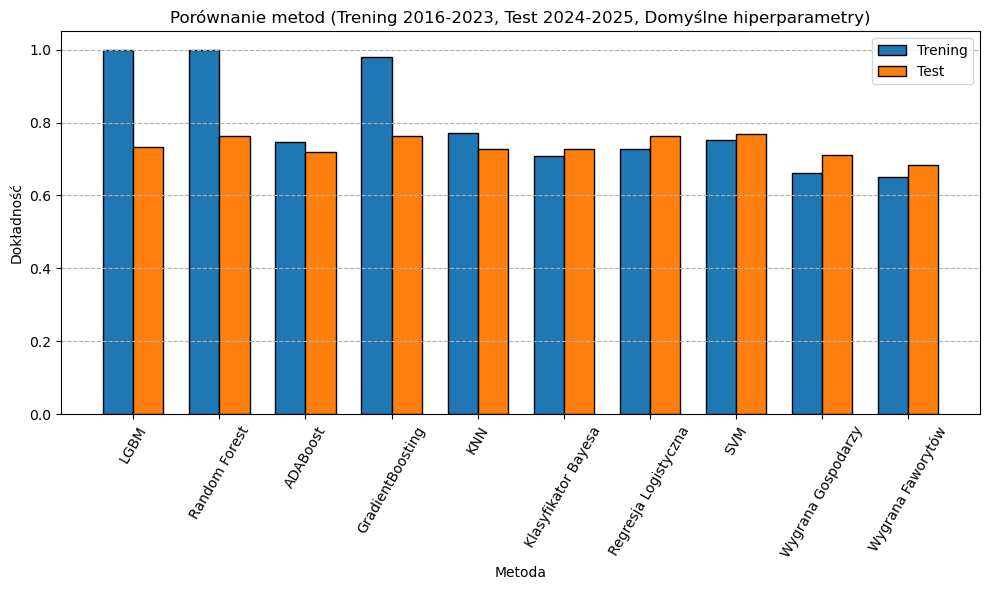

[1.0, 1.0, 0.7476099426386233, 0.9789674952198852, 0.7705544933078394, 0.7074569789674953, 0.7284894837476099, 0.751434034416826, 0.6615678776290631, 0.6500956022944551]
[0.7338129496402878, 0.762589928057554, 0.7194244604316546, 0.762589928057554, 0.7266187050359713, 0.7266187050359713, 0.762589928057554, 0.7697841726618705, 0.7122302158273381, 0.6834532374100719]


In [41]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

x = np.arange(len(methods))
width = 0.35                  

plt.figure(figsize=(10,6))

plt.bar(x - width/2, ACC_train, width, label='Trening',edgecolor='black')
plt.bar(x + width/2, ACC_test,  width, label='Test', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=60)

plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie metod (Trening 2016-2023, Test 2024-2025, Domyślne hiperparametry)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

print(ACC_train)
print(ACC_test)

In [42]:
def get_model(method):
    if method == 'lgbmc':
        return LGBMClassifier(
               num_class=3, objective='multiclass', random_state=42,
               verbose=-1
        )

    elif method == 'rfc':
        return RandomForestClassifier(random_state=42)

    elif method == 'adac':
        return AdaBoostClassifier(random_state=42)

    elif method == 'gbc':
        return GradientBoostingClassifier(random_state=42)

    elif method == 'knn':
        return Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

    elif method == 'dt':
        return DecisionTreeClassifier(max_depth=1, random_state=42)
    
    elif method == 'nb':
        return GaussianNB()

    elif method == 'rl':
        return Pipeline([
            ('scaler',StandardScaler()),
            ('logreg',LogisticRegression(multi_class='multinomial', random_state=42))
        ])
    elif method == 'svm':
        return Pipeline([
            ('scaler',StandardScaler()),
            ('svm',SVC(kernel='rbf'))
            ])
    return None

Walidacja krzyżowa ze stałym oknem kroczącym

In [43]:
def cross_validate_sliding_window(df, window, features, training_window_size=4, method='lgbmc', start_season=None, optimal = False, results_registry = None):
 
    df = inz_cech(df,window)
    df = df[df['Sezon'] > 2015]
    df_cv = df.sort_values(by=['Sezon', 'Data']).reset_index(drop=True)

    if start_season is not None:
         df = df[df['Sezon'] >= start_season].copy()

    all_seasons = sorted(df_cv['Sezon'].unique())
            
    seasons_to_test = all_seasons[training_window_size:]
    
    X = df_cv[features].copy()
    y = df_cv['Wynik_meczu']
    
    acc_scores_train = []
    acc_scores_val = []

    for fold, val_season in enumerate(seasons_to_test):
        
        val_index = df_cv[df_cv['Sezon'] == val_season].index
        
        end_train_season = val_season - 1

        start_train_season = val_season - training_window_size
        
        train_seasons = list(range(start_train_season, end_train_season + 1))
        
        train_condition = (df_cv['Sezon'] >= start_train_season) & (df_cv['Sezon'] <= end_train_season)
        train_index = df_cv[train_condition].index

        X_train, X_val = X.loc[train_index], X.loc[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]


        if method in ['gosp', 'faworyt']:
            if method == 'gosp': 
                y_pred_val = np.full(len(y_val),2)
                y_pred_train = np.full(len(y_train),2)

            elif method == 'faworyt':
                choices = [0, 2, 1] 
                y_pred_val = np.select([X_val['Sila_druzyny_gospodarzy'] < X_val['Sila_druzyny_gosci'], 
                                        X_val['Sila_druzyny_gospodarzy'] > X_val['Sila_druzyny_gosci'], 
                                        X_val['Sila_druzyny_gospodarzy'] == X_val['Sila_druzyny_gosci']], choices, default=-1)
                y_pred_train = np.select([X_train['Sila_druzyny_gospodarzy'] < X_train['Sila_druzyny_gosci'], 
                                          X_train['Sila_druzyny_gospodarzy'] > X_train['Sila_druzyny_gosci'], 
                                          X_train['Sila_druzyny_gospodarzy'] == X_train['Sila_druzyny_gosci']], choices, default=-1)

        else:
            if optimal:
                model = results_registry[method][window[0]]['model']
            else:
                model = get_model(method)
            model.fit(X_train, y_train)
            
            y_pred_val = model.predict(X_val)
            y_pred_train = model.predict(X_train)

        acc_val = accuracy_score(y_val, y_pred_val)
        acc_train = accuracy_score(y_train, y_pred_train)
        
        
        acc_scores_train.append(acc_train)
        acc_scores_val.append(acc_val)

        
    return acc_scores_val, acc_scores_train

In [44]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
ACC_train = []
ACC_test = []
test_seasons = [2020,2021,2022, 2023]

for model in methods:
    print(f'\n{model}')
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
    wynik = cross_validate_sliding_window(df, features = features,window = [3, 3],method=model,training_window_size=4) 
    print(f'Test: {pd.Series(wynik[0]).describe()} \n')
    print(f'Trening: {pd.Series(wynik[1]).describe()}\n')
    ACC_test.append(wynik[0])
    ACC_train.append(wynik[1])


lgbmc
Test: count    4.000000
mean     0.649355
std      0.066559
min      0.562500
25%      0.616815
50%      0.660317
75%      0.692857
max      0.714286
dtype: float64 

Trening: count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64


rfc
Test: count    4.000000
mean     0.683966
std      0.036589
min      0.640625
25%      0.660156
50%      0.690476
75%      0.714286
max      0.714286
dtype: float64 

Trening: count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64


adac
Test: count    4.000000
mean     0.737773
std      0.034400
min      0.698413
25%      0.721032
50%      0.735714
75%      0.752455
max      0.781250
dtype: float64 

Trening: count    4.000000
mean     0.761427
std      0.006811
min      0.752941
25%      0.758824
50%      0.761618
75%      0.764222
max      0.769531
dtype: float64


gbc
Test: count    4.000000
mean     0.636992
std    

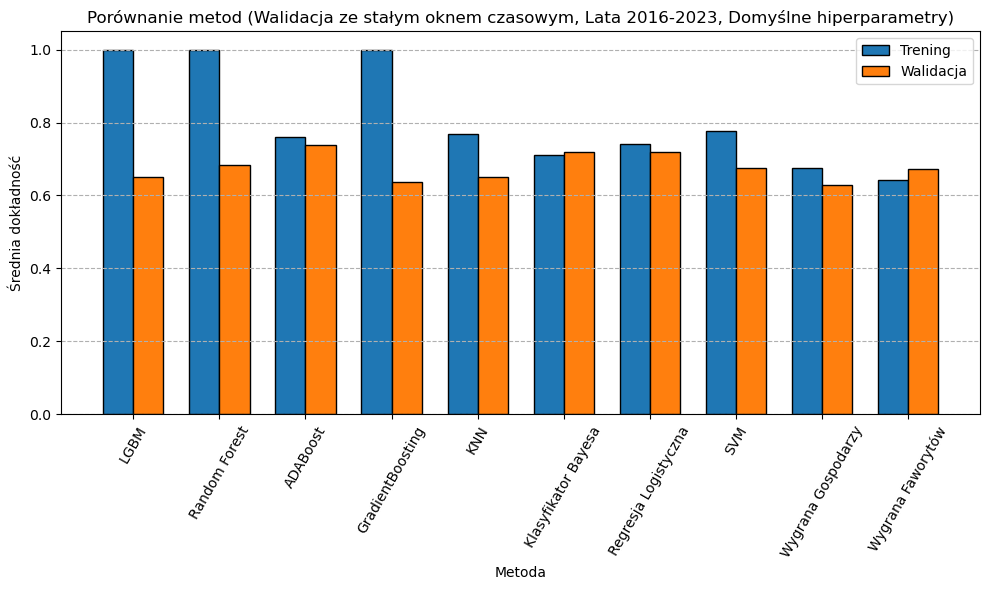

In [45]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

x = np.arange(len(methods))
width = 0.35                      

plt.figure(figsize=(10,6))

plt.bar(x - width/2, np.mean(ACC_train,axis=1), width, label='Trening',edgecolor='black')
plt.bar(x + width/2, np.mean(ACC_test,axis=1),  width, label='Walidacja', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Średnia dokładność')
plt.title('Porównanie metod (Walidacja ze stałym oknem czasowym, Lata 2016-2023, Domyślne hiperparametry)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

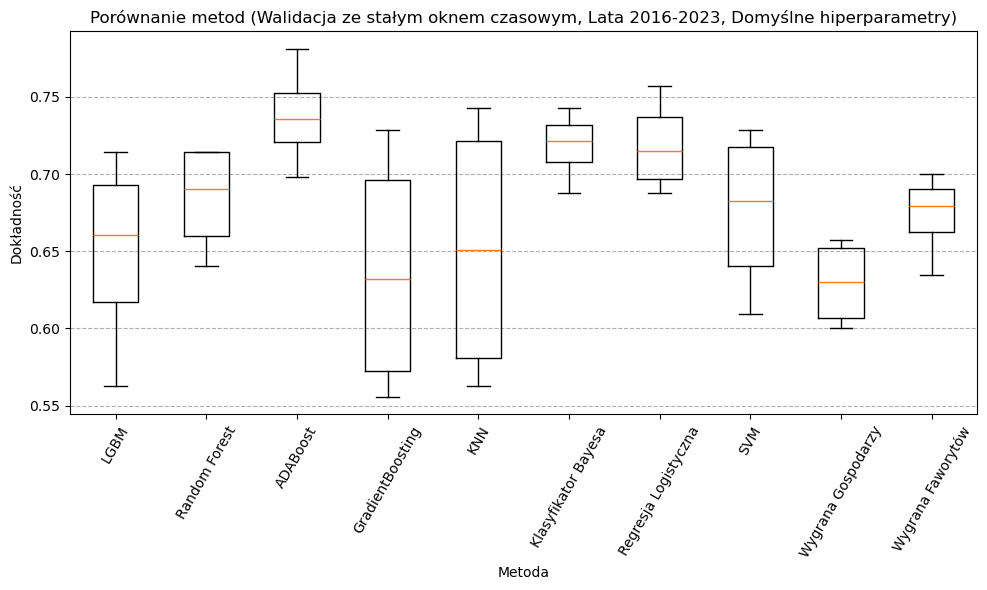

In [46]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

plt.figure(figsize=(10,6))

plt.boxplot(ACC_test)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10], labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie metod (Walidacja ze stałym oknem czasowym, Lata 2016-2023, Domyślne hiperparametry)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

Tuning hiperparametrów

In [47]:
class SlidingWindowSplit(BaseCrossValidator):
    def __init__(self, df, training_window_size=4):
        self.all_seasons = sorted(df['Sezon'].unique())
        self.training_window_size = training_window_size
        self.df = df 
        
        if len(self.all_seasons) < training_window_size + 1:
            self.val_seasons = []
        else:
            self.val_seasons = self.all_seasons[training_window_size:]

    def split(self, X, y=None, groups=None):
        
        for val_season in self.val_seasons:
            
            val_index = self.df[self.df['Sezon'] == val_season].index
            
            end_train_season = val_season - 1
            start_train_season = val_season - self.training_window_size
            
            train_condition = (self.df['Sezon'] >= start_train_season) & (self.df['Sezon'] <= end_train_season)
            train_index = self.df[train_condition].index
            
            yield train_index, val_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.val_seasons)

In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def tune_model_with_sliding_window(df, window, features, training_window_size=4, method='lgbmc', n_iter=50, start_season=None):

    df = inz_cech(df, window)
    df = df[df['Sezon'] > 2015]
    df_cv = df.sort_values(by=['Sezon', 'Data']).reset_index(drop=True)

    if start_season is not None:
         df_cv = df_cv[df_cv['Sezon'] >= start_season].copy()

    X = df_cv[features].copy()
    y = df_cv['Wynik_meczu']

    sliding_splitter = SlidingWindowSplit(df=df_cv, training_window_size=training_window_size)
    
    def objective(trial):
        model = get_model(method)

        params = {}
        
        if method == 'lgbmc':
            params = {
                'objective': 'multiclass',
                'num_class': 3,
                'n_estimators': trial.suggest_int('n_estimators', 20, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
                'max_depth': trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, -1]),
                'num_leaves': trial.suggest_int('num_leaves', 5, 50),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 80, step=5),
                'feature_fraction': trial.suggest_categorical('feature_fraction', [0.7, 0.8, 0.9]),
                'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.7, 0.8, 0.9]),
                'lambda_l1': trial.suggest_categorical('lambda_l1', [0.0, 0.1, 0.5]),
                'lambda_l2': trial.suggest_categorical('lambda_l2', [0.0, 0.1, 0.5]),
                'random_state': 42,
                'verbose': -1
            }
            
        elif method == 'rfc':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 20, 500),
                'max_features': trial.suggest_categorical('max_features', [0.8, 1.0, 'sqrt', 'log2']),
                'max_depth': trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, None]),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': 42
            }
            
        elif method == 'knn':
            params = {
                'knn__n_neighbors': trial.suggest_int('knn__n_neighbors', 1, 35)
            }
            
        elif method == 'gbc':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 20, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 1, 5),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8]),
                'random_state': 42
            }
            
        elif method == 'adac':
            max_depth_base = trial.suggest_int('estimator__max_depth', 1, 3)
            base_estimator = DecisionTreeClassifier(max_depth=max_depth_base, random_state=42)
            
            model.set_params(estimator=base_estimator) 
            
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
                'random_state': 42
            }

        elif method == 'rl':
            params = {
                'logreg__C': trial.suggest_float('logreg__C', 1e-4, 1e4, log=True),
                'logreg__penalty': trial.suggest_categorical('logreg__penalty', ['l2']),
                'logreg__solver': trial.suggest_categorical('logreg__solver', ['lbfgs']),
                'logreg__fit_intercept': trial.suggest_categorical('logreg__fit_intercept', [True, False]),
                'logreg__max_iter': trial.suggest_categorical('logreg__max_iter', [100, 500, 1000]),
                'logreg__random_state': 42
            }
            
        elif method == 'nb':
            params = {
                'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-5, log=True)
            }
            
        elif method == 'svm':
            params = {
                'svm__C': trial.suggest_float('svm__C', 0.01, 1000, log=True),
                'svm__gamma': trial.suggest_categorical('svm__gamma', ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10])
            }

        model.set_params(**params)

        scores = cross_val_score(model, X, y, cv=sliding_splitter, scoring='accuracy', n_jobs=-1)
        
        return scores.mean()

    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='maximize',sampler=sampler)
    print(f"Rozpoczynam optymalizację Optuna dla {method.upper()} na {n_iter} iteracji...")
    
    study.optimize(objective, n_trials=n_iter)

    best_score = study.best_value
    best_params = study.best_params
    
    print(f"Najlepsza średnia dokładność: {best_score:.4f}")
    print(f"Optymalne hiperparametry: {best_params}")

    best_model = get_model(method)

    if method == 'adac' and 'estimator__max_depth' in best_params:
        depth = best_params.pop('estimator__max_depth')
        best_model.set_params(estimator=DecisionTreeClassifier(max_depth=depth))
    
    best_model.set_params(**best_params)

    best_model.fit(X, y)

    return best_model, best_score, best_params

In [49]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm']
results_registry = {}

for method in methods:
    print(f'\nMetoda: {method}\n')
    results_registry[method] = {}
    for i in range(1,6,1):
        print(f'\nRozmiar okna do liczenia formy drużyny: {i} \n')
        df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
        best_model,_,_ = tune_model_with_sliding_window(df, features = features,window= [i, i],method=method,training_window_size=4)
        results_registry[method][i] = {'model': best_model}
        print(best_model)


Metoda: lgbmc


Rozmiar okna do liczenia formy drużyny: 1 

Rozpoczynam optymalizację Optuna dla LGBMC na 50 iteracji...
Najlepsza średnia dokładność: 0.7427
Optymalne hiperparametry: {'n_estimators': 418, 'learning_rate': 0.00743274556639191, 'max_depth': 1, 'num_leaves': 11, 'min_child_samples': 80, 'feature_fraction': 0.7, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.5}
LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.7, lambda_l1=0.1,
               lambda_l2=0.5, learning_rate=0.00743274556639191, max_depth=1,
               min_child_samples=80, n_estimators=418, num_class=3,
               num_leaves=11, objective='multiclass', random_state=42,
               verbose=-1)

Rozmiar okna do liczenia formy drużyny: 2 

Rozpoczynam optymalizację Optuna dla LGBMC na 50 iteracji...
Najlepsza średnia dokładność: 0.7541
Optymalne hiperparametry: {'n_estimators': 414, 'learning_rate': 0.0050386693663598036, 'max_depth': 1, 'num_leaves': 18, 'min_child_samples': 80, 'f

Wybranie okien dających najlepsze rezultaty

In [50]:
windows = [2,2,4,2,4,1,1,4]

In [51]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
ACC_train = []
ACC_test = []
test_seasons = [2020,2021,2022,2023]

for i,model in enumerate(methods):
    if i +1 <= len(windows):
        j = windows[i]
    else:
        j = 3
    print(f'{model}\n')
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
    wynik = cross_validate_sliding_window(df,features=features, window=[j, j],method=model,training_window_size=4, optimal = True, results_registry=results_registry) 
    print(f'Test: {pd.Series(wynik[0]).describe()} \n')
    print(f'Trening: {pd.Series(wynik[1]).describe()}\n')
    ACC_test.append(wynik[0])
    ACC_train.append(wynik[1])

lgbmc

Test: count    4.000000
mean     0.754105
std      0.033708
min      0.714286
25%      0.735714
50%      0.754241
75%      0.772631
max      0.793651
dtype: float64 

Trening: count    4.000000
mean     0.746726
std      0.023217
min      0.718750
25%      0.732629
50%      0.749020
75%      0.763117
max      0.770115
dtype: float64

rfc

Test: count    4.000000
mean     0.765092
std      0.026832
min      0.742857
25%      0.742857
50%      0.760317
75%      0.782552
max      0.796875
dtype: float64 

Trening: count    4.000000
mean     0.738887
std      0.025533
min      0.714844
25%      0.719887
50%      0.735294
75%      0.754293
max      0.770115
dtype: float64

adac

Test: count    4.000000
mean     0.768390
std      0.029048
min      0.728571
25%      0.756362
50%      0.775670
75%      0.787698
max      0.793651
dtype: float64 

Trening: count    4.000000
mean     0.771044
std      0.021441
min      0.752941
25%      0.753665
50%      0.767149
75%      0.784528
max     

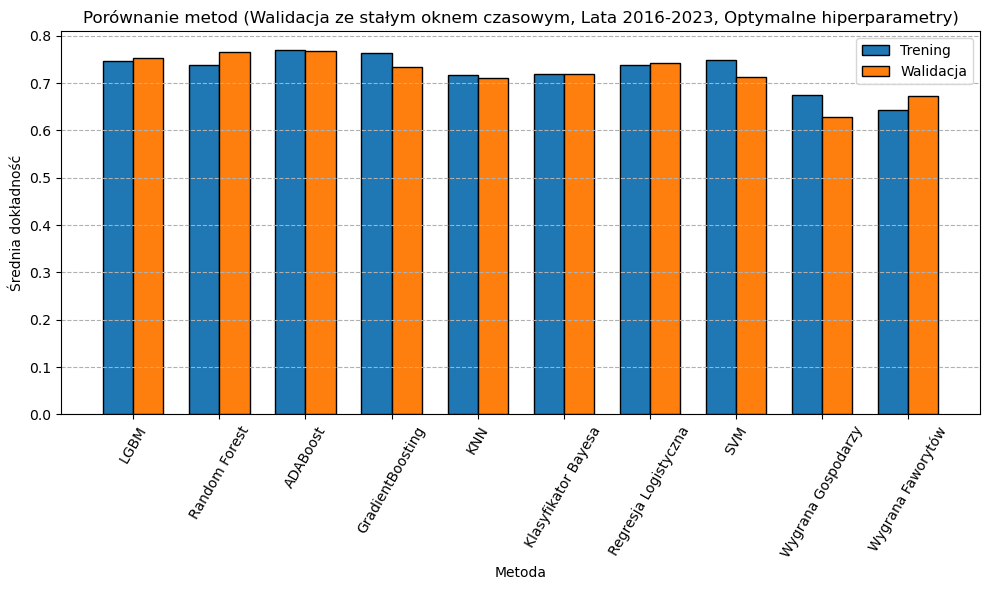

In [52]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

x = np.arange(len(methods))
width = 0.35                      

plt.figure(figsize=(10,6))

plt.bar(x - width/2, np.mean(ACC_train,axis=1), width, label='Trening',edgecolor='black')
plt.bar(x + width/2, np.mean(ACC_test,axis=1),  width, label='Walidacja', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Średnia dokładność')
plt.title('Porównanie metod (Walidacja ze stałym oknem czasowym, Lata 2016-2023, Optymalne hiperparametry)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

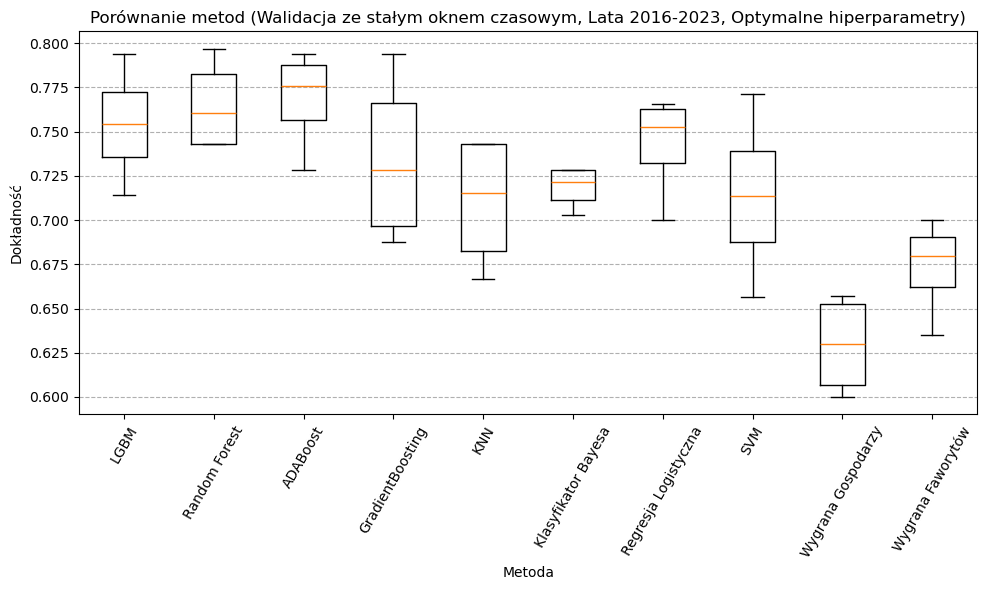

In [53]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

plt.figure(figsize=(10,6))

plt.boxplot(ACC_test)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10], labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie metod (Walidacja ze stałym oknem czasowym, Lata 2016-2023, Optymalne hiperparametry)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [54]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm']
ACC_test = []
ACC_test_optimal = []
test_seasons = [2020,2021,2022,2023]


for i,model in enumerate(methods):
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
    wynik = cross_validate_sliding_window(df,features=features, window=[3, 3],method=model,training_window_size=4, optimal = False, results_registry=results_registry) 
    
    ACC_test.append(wynik[0])

for i,model in enumerate(methods):
    if i +1 <= len(windows):
        j = windows[i]
    else:
        j = 3
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
    wynik = cross_validate_sliding_window(df,features=features, window=[j, j],method=model,training_window_size=4, optimal = True, results_registry=results_registry) 
    
    ACC_test_optimal.append(wynik[0])

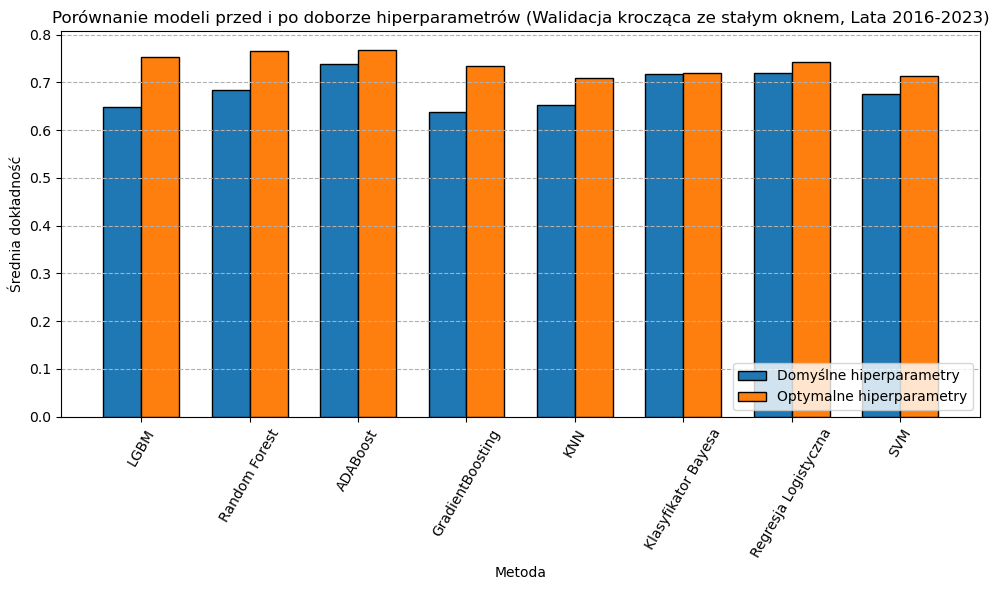

In [55]:
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM']

x = np.arange(len(methods))
width = 0.35                      

plt.figure(figsize=(10,6))

plt.bar(x - width/2, np.mean(ACC_test,axis=1), width, label='Domyślne hiperparametry',edgecolor='black')
plt.bar(x + width/2, np.mean(ACC_test_optimal,axis=1),  width, label='Optymalne hiperparametry', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Średnia dokładność')
plt.title('Porównanie modeli przed i po doborze hiperparametrów (Walidacja krocząca ze stałym oknem, Lata 2016-2023)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.show()

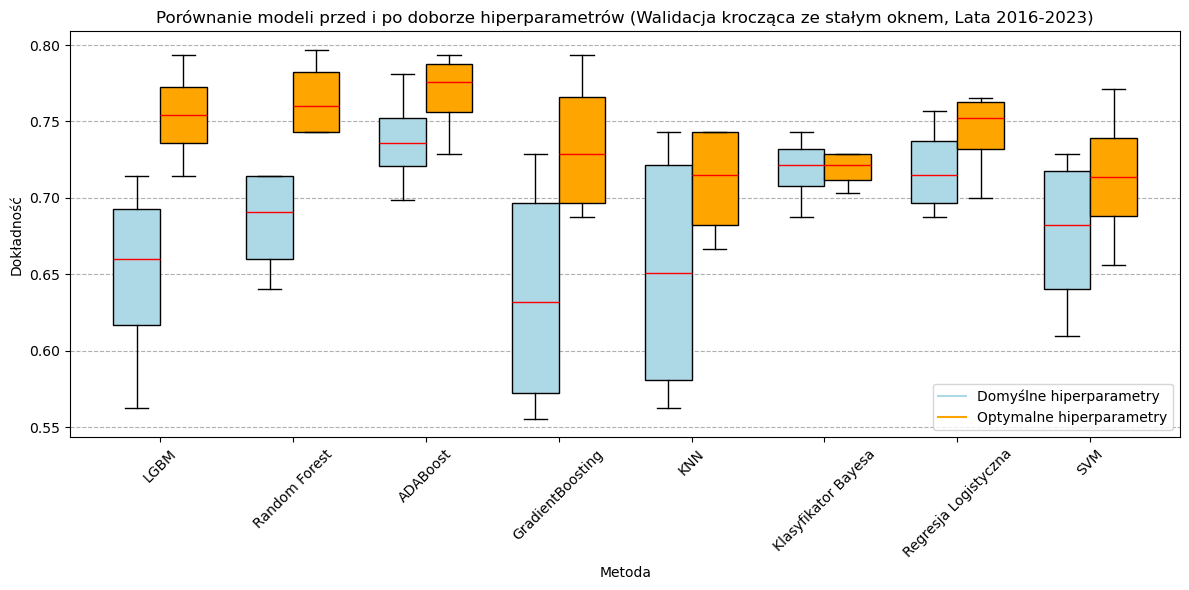

In [56]:
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM']

x = np.arange(len(nowe_nazwy))
width = 0.35                    

plt.figure(figsize=(12, 6))

bpl = plt.boxplot(ACC_test, positions=x - width/2, sym='', widths=width, patch_artist=True)


bpr = plt.boxplot(ACC_test_optimal, positions=x + width/2, sym='', widths=width, patch_artist=True)


colors = ['lightblue', 'orange']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], facecolor=color)
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='red')

set_box_color(bpl, colors[0])
set_box_color(bpr, colors[1])


plt.plot([], c=colors[0], label='Domyślne hiperparametry')
plt.plot([], c=colors[1], label='Optymalne hiperparametry')
plt.legend(loc='lower right')

plt.xticks(x, labels=nowe_nazwy, rotation=45)
plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie modeli przed i po doborze hiperparametrów (Walidacja krocząca ze stałym oknem, Lata 2016-2023)')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [57]:
def test_model_optimal(df, window, features, method = 'lgbmc',results_registry = None):

    df = inz_cech(df,window)

    X = df[features].copy()
    y = df['Wynik_meczu']


    X_train = X[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
    y_train = y[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]

    X_test = X[df['Sezon'].isin([2024,2025])]
    y_test = y[df['Sezon'].isin([2024,2025])]

    if method == 'gosp':
        y_pred = np.full(len(y_test),2)
        y_pred_train = np.full(len(y_train),2)
    elif method == 'faworyt':
        conditions = [
        X_test['Sila_druzyny_gospodarzy'] < X_test['Sila_druzyny_gosci'],
        X_test['Sila_druzyny_gospodarzy'] > X_test['Sila_druzyny_gosci'],
        X_test['Sila_druzyny_gospodarzy'] == X_test['Sila_druzyny_gosci']
        ]

        conditions_train = [
        X_train['Sila_druzyny_gospodarzy'] < X_train['Sila_druzyny_gosci'],
        X_train['Sila_druzyny_gospodarzy'] > X_train['Sila_druzyny_gosci'],
        X_train['Sila_druzyny_gospodarzy'] == X_train['Sila_druzyny_gosci']
        ]

        choices = [0, 2, 1]

        y_pred = np.select(conditions, choices, default=-1)
        y_pred_train = np.select(conditions_train, choices, default=-1) 
    else:
        model = results_registry[method][window[0]]['model']
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)

    return acc_test, acc_train

In [58]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
ACC_train = []
ACC_test = []

for i,model in enumerate(methods):
    
    if i +1 <= len(windows):
        j = windows[i]
    else:
        j = 3
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
    wynik = test_model_optimal(df, [j, j],method=model,features=features,results_registry=results_registry) 
    
    ACC_test.append(wynik[0])
    ACC_train.append(wynik[1])

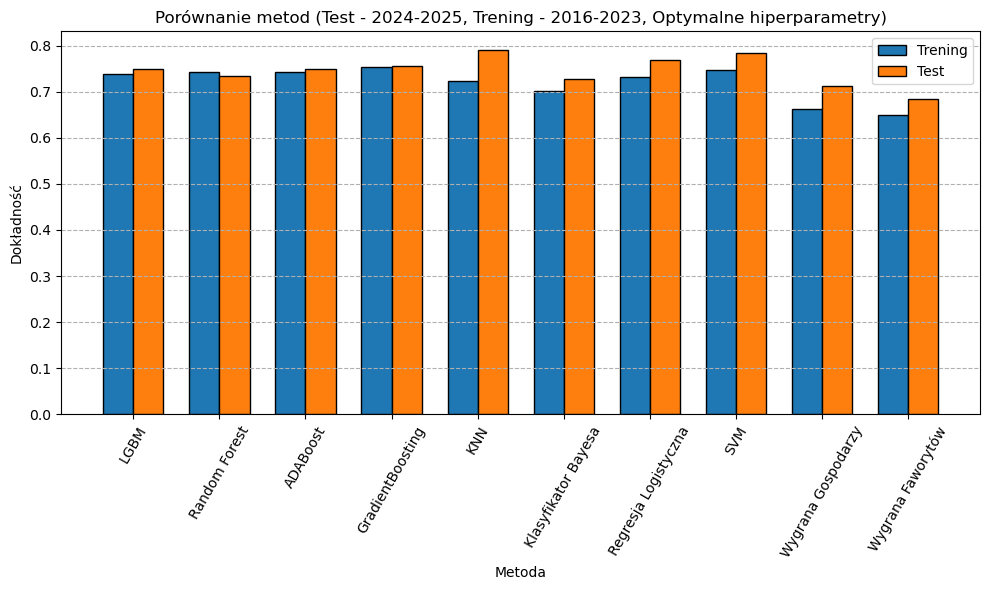

[0.7380497131931166, 0.7437858508604207, 0.7437858508604207, 0.7533460803059273, 0.722753346080306, 0.7017208413001912, 0.7323135755258127, 0.7476099426386233, 0.6615678776290631, 0.6500956022944551]
[0.7482014388489209, 0.7338129496402878, 0.7482014388489209, 0.7553956834532374, 0.7913669064748201, 0.7266187050359713, 0.7697841726618705, 0.7841726618705036, 0.7122302158273381, 0.6834532374100719]


In [59]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm','gosp','faworyt']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM','Wygrana Gospodarzy','Wygrana Faworytów']

x = np.arange(len(methods))
width = 0.35                      

plt.figure(figsize=(10,6))

plt.bar(x - width/2, ACC_train, width, label='Trening',edgecolor='black')
plt.bar(x + width/2, ACC_test,  width, label='Test', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie metod (Test - 2024-2025, Trening - 2016-2023, Optymalne hiperparametry)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

print(ACC_train)
print(ACC_test)

In [60]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm']
ACC_train_domyslne = []
ACC_test_domyslne = []

for model in methods:
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
    wynik = test_model(df, features= features,window = [3, 3],method=model) 
    
    ACC_test_domyslne.append(wynik[0])
    ACC_train_domyslne.append(wynik[1])


ACC_train_optymalne = []
ACC_test_optymalne = []

for i,model in enumerate(methods):
    
    if i +1 <= len(windows):
        j = windows[i]
    else:
        j = 3
    df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
    wynik = test_model_optimal(df, [j, j],method=model,features=features,results_registry=results_registry) 
    
    ACC_test_optymalne.append(wynik[0])
    ACC_train_optymalne.append(wynik[1])

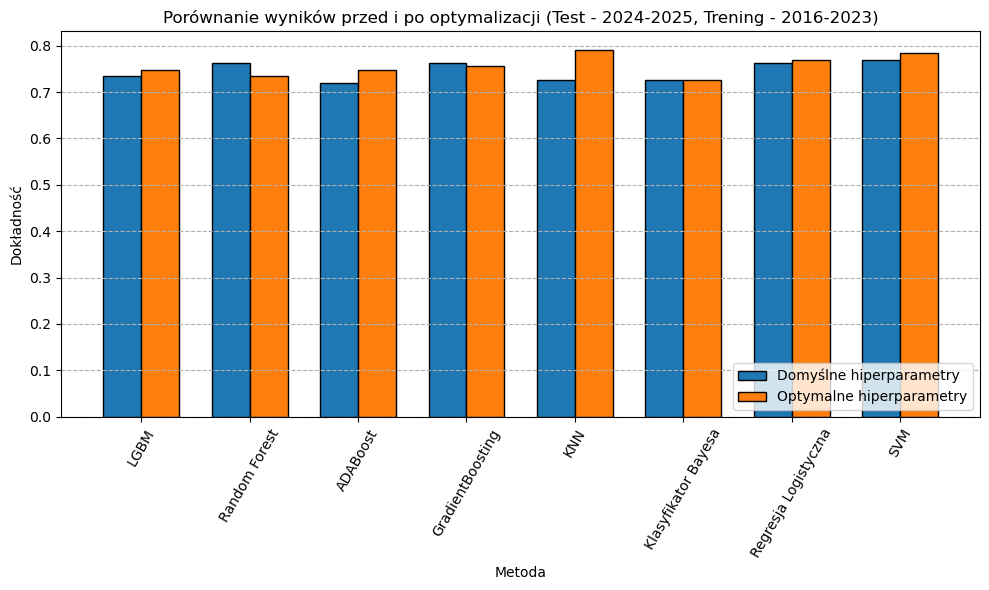

[0.7338129496402878, 0.762589928057554, 0.7194244604316546, 0.762589928057554, 0.7266187050359713, 0.7266187050359713, 0.762589928057554, 0.7697841726618705]
[0.7482014388489209, 0.7338129496402878, 0.7482014388489209, 0.7553956834532374, 0.7913669064748201, 0.7266187050359713, 0.7697841726618705, 0.7841726618705036]


In [61]:
methods = ['lgbmc','rfc','adac','gbc','knn','nb','rl','svm']
nowe_nazwy = ['LGBM', 'Random Forest', 'ADABoost','GradientBoosting','KNN','Klasyfikator Bayesa','Regresja Logistyczna','SVM']

x = np.arange(len(methods))
width = 0.35                      

plt.figure(figsize=(10,6))

plt.bar(x - width/2, ACC_test_domyslne, width, label='Domyślne hiperparametry',edgecolor='black')
plt.bar(x + width/2, ACC_test_optymalne,  width, label='Optymalne hiperparametry', edgecolor='black')
plt.xticks(x,labels=nowe_nazwy, rotation=45)

plt.xlabel('Metoda')
plt.ylabel('Dokładność')
plt.title('Porównanie wyników przed i po optymalizacji (Test - 2024-2025, Trening - 2016-2023)')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.show()

print(ACC_test_domyslne)
print(ACC_test_optymalne)

# 4. Szczegółowe wyniki wybranych modeli

In [62]:
features_full = [
        'Drużyna gospodarzy', 'Drużyna gości',
        'Punkty gospodarzy', 'Punkty gości',
        'Kolejka', 'Sezon'
        ,'Forma_gospodarz_dom','Forma_gosc_wyjazd'
        ,'Różnica_form'
        ,'Sila_druzyny_gospodarzy','Sila_druzyny_gosci'
        ,'Różnica_sił'
        ,'Sila_Seniorzy_Gospodarze', 'Sila_Seniorzy_Goscie'
        ,'Różnica_Seniorzy'
        ,'Sila_Juniorzy_Gospodarze', 'Sila_Juniorzy_Goscie'
        ,'Różnica_Juniorzy' 
    ]

Dokładność (Accuracy): 0.7914

Skuteczność przewidywania zwycięzcy na zbiorze treningowym: 72%
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.62      0.69      0.66        36
           1       0.00      0.00      0.00         4
           2       0.86      0.86      0.86        99

    accuracy                           0.79       139
   macro avg       0.49      0.52      0.51       139
weighted avg       0.77      0.79      0.78       139

Macierz Pomyłek:
[[25  0 11]
 [ 1  0  3]
 [14  0 85]]


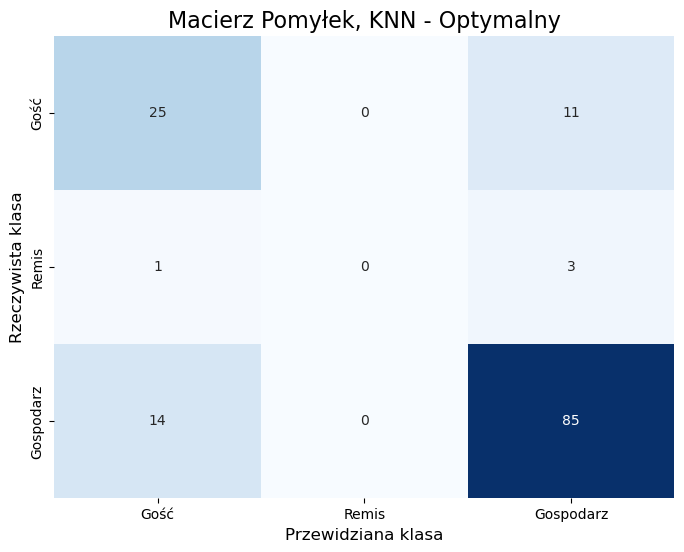

In [63]:
df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
df = inz_cech(df,[4,4])
df = df[df['Sezon'] > 2015]
df = df.sort_values(by=['Sezon', 'Data']).reset_index(drop=True)

X_full = df[features_full].copy()
X = df[features].copy()
y = df['Wynik_meczu']


X_train = X[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
y_train = y[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]

X_test = X[df['Sezon'].isin([2024,2025])]
y_test = y[df['Sezon'].isin([2024,2025])]

X_test_full = X_full[df['Sezon'].isin([2024,2025])]


model = results_registry['knn'][4]['model']


model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred_train = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)

print(f"Dokładność (Accuracy): {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Skuteczność przewidywania zwycięzcy na zbiorze treningowym: {acc_train:.0%}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Macierz Pomyłek:")
print(cm)
class_names = {'Gość': 0, 'Remis': 1 , 'Gospodarz': 2 }

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d',  
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Macierz Pomyłek, KNN - Optymalny', fontsize=16)
plt.xlabel('Przewidziana klasa', fontsize=12)
plt.ylabel('Rzeczywista klasa', fontsize=12)
plt.show()

In [64]:
class_map = {0: 'Gość', 1: 'Remis', 2: 'Gospodarz'}
results = pd.DataFrame({
    'Sezon': X_test_full['Sezon'].values,
    'Kolejka': X_test_full['Kolejka'].values,
    'Gospodarz': X_test_full['Drużyna gospodarzy'].values,
    'Gość': X_test_full['Drużyna gości'].values,
    'Punkty gosp.':X_test_full['Punkty gospodarzy'].values,
    'Punkty gości': X_test_full['Punkty gości'].values,
    'Rzeczywisty': y_test.map(class_map).values,
    'Prognoza': [class_map[p] for p in y_pred],
    'Pewność (Gosp.)': [f"{prob*100:.0f}%" for prob in y_proba[:, 2]],
    'Pewność (Gość)': [f"{prob*100:.0f}%" for prob in y_proba[:, 0]],
    'Pewność (Remis)': [f"{prob*100:.0f}%" for prob in y_proba[:, 1]]
})

results.sample(10)

,Sezon,Kolejka,Gospodarz,Gość,Punkty gosp.,Punkty gości,Rzeczywisty,Prognoza,Pewność (Gosp.),Pewność (Gość),Pewność (Remis)
89,2025,6,RYBNIK,WROCŁAW,40.0,50.0,Gość,Gość,23%,71%,6%
90,2025,6,CZĘSTOCHOWA,ZIELONA,42.0,48.0,Gość,Gość,45%,55%,0%
56,2024,15,WROCŁAW,GRUDZIĄDZ,50.0,40.0,Gospodarz,Gospodarz,90%,3%,6%
45,2024,12,TORUŃ,CZĘSTOCHOWA,49.0,41.0,Gospodarz,Gospodarz,55%,39%,6%
58,2024,16,GRUDZIĄDZ,WROCŁAW,41.0,49.0,Gość,Gość,45%,52%,3%
96,2025,8,RYBNIK,ZIELONA,36.0,53.0,Gość,Gość,23%,65%,13%
38,2024,10,ZIELONA,LESZNO,53.0,37.0,Gospodarz,Gospodarz,94%,6%,0%
69,2025,1,ZIELONA,LUBLIN,31.0,59.0,Gość,Gość,32%,58%,10%
103,2025,9,GRUDZIĄDZ,TORUŃ,44.0,46.0,Gość,Gospodarz,87%,10%,3%
46,2024,12,LESZNO,WROCŁAW,47.0,43.0,Gospodarz,Gospodarz,71%,29%,0%


Dokładność (Accuracy): 0.7626

Skuteczność przewidywania zwycięzcy na zbiorze treningowym: 100%
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        36
           1       0.00      0.00      0.00         4
           2       0.81      0.87      0.84        99

    accuracy                           0.76       139
   macro avg       0.47      0.47      0.47       139
weighted avg       0.73      0.76      0.75       139

Macierz Pomyłek:
[[20  0 16]
 [ 0  0  4]
 [13  0 86]]


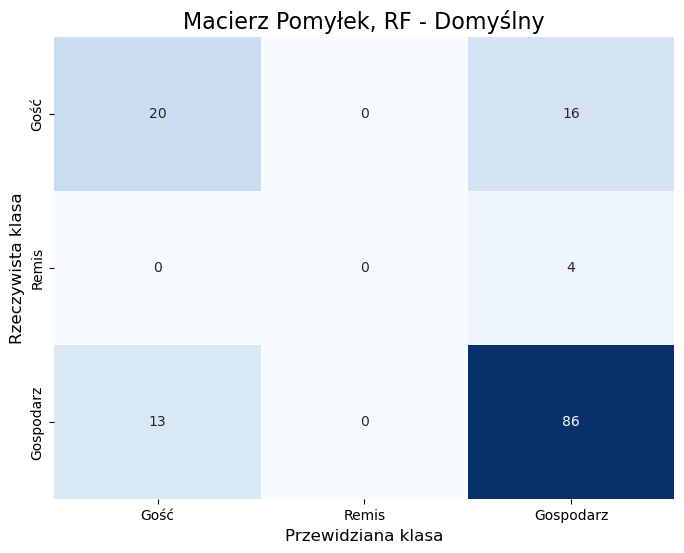

In [65]:
df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
df = inz_cech(df,[3,3])
df = df[df['Sezon'] > 2015]
df = df.sort_values(by=['Sezon', 'Data']).reset_index(drop=True)

X_full = df[features_full].copy()
X = df[features].copy()
y = df['Wynik_meczu']


X_train = X[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
y_train = y[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]

X_test = X[df['Sezon'].isin([2024,2025])]
y_test = y[df['Sezon'].isin([2024,2025])]

X_test_full = X_full[df['Sezon'].isin([2024,2025])]


model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred_train = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)

print(f"Dokładność (Accuracy): {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Skuteczność przewidywania zwycięzcy na zbiorze treningowym: {acc_train:.0%}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Macierz Pomyłek:")
print(cm)
class_names = {'Gość': 0, 'Remis': 1 , 'Gospodarz': 2 }

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d',  
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Macierz Pomyłek, RF - Domyślny', fontsize=16)
plt.xlabel('Przewidziana klasa', fontsize=12)
plt.ylabel('Rzeczywista klasa', fontsize=12)
plt.show()


Dokładność (Accuracy): 0.7338

Skuteczność przewidywania zwycięzcy na zbiorze treningowym: 74%
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60        36
           1       0.00      0.00      0.00         4
           2       0.85      0.77      0.81        99

    accuracy                           0.73       139
   macro avg       0.46      0.50      0.47       139
weighted avg       0.74      0.73      0.73       139

Macierz Pomyłek:
[[26  0 10]
 [ 1  0  3]
 [23  0 76]]


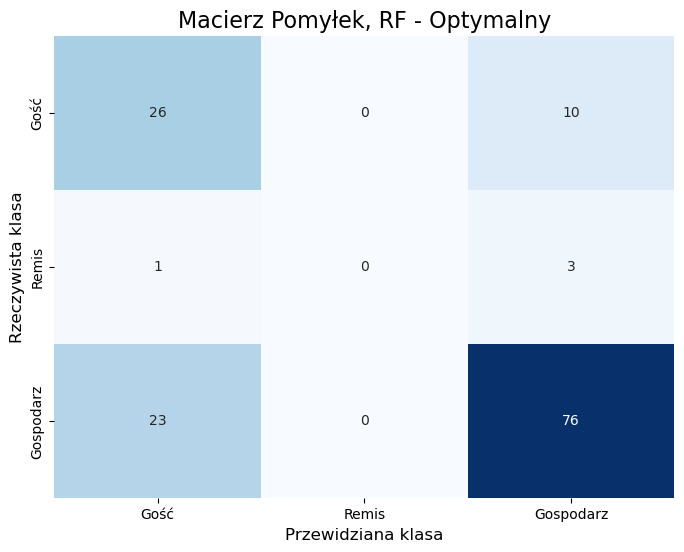

In [66]:
df = pd.concat([df_2015,df_2016,df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
df = inz_cech(df,[2,2])
df = df[df['Sezon'] > 2015]
df = df.sort_values(by=['Sezon', 'Data']).reset_index(drop=True)

X_full = df[features_full].copy()
X = df[features].copy()
y = df['Wynik_meczu']


X_train = X[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]
y_train = y[df['Sezon'].isin([2016,2017,2018,2019,2020,2021,2022,2023])]

X_test = X[df['Sezon'].isin([2024,2025])]
y_test = y[df['Sezon'].isin([2024,2025])]

X_test_full = X_full[df['Sezon'].isin([2024,2025])]


model = results_registry['rfc'][2]['model']


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred_train = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)

print(f"Dokładność (Accuracy): {accuracy_score(y_test, y_pred):.4f}\n")
print(f"Skuteczność przewidywania zwycięzcy na zbiorze treningowym: {acc_train:.0%}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Macierz Pomyłek:")
print(cm)
class_names = {'Gość': 0, 'Remis': 1 , 'Gospodarz': 2 }

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d',  
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Macierz Pomyłek, RF - Optymalny', fontsize=16)
plt.xlabel('Przewidziana klasa', fontsize=12)
plt.ylabel('Rzeczywista klasa', fontsize=12)
plt.show()
